# A PVLIB-Python Simulation for the *Los Andes University* Solar System
Based on: https://pvlib-python.readthedocs.io/en/stable/.

By Nelson Andrés Salazar Peña (na.salazar10@uniandes.edu.co).
___
### Table of Contents
#### Part 1: Accesing Forecast Data
- 1.1. Introducing First the Main Modules and Supporting Features
- 1.2. Choose a Locationd and Time
- 1.3. Forecast Models from Unidata Thredds Server
- 1.4. Retrieve Data from Unidata Thredds Server Model
- 1.5. Process Data Class

#### Part 2: Cloud Cover Irradiation
- 2.1. Cloud Cover Forecast
- 2.2. Irradiance Forecast

#### Part 3: Weather Models

#### Part 4: Calculating Modeling Intermediates
- 4.1. Solar Position
- 4.2. Extraterrestrial DNI
- 4.3. Airmass
- 4.4. Plane of Array (POA)
- 4.5. Angle of Incidente (AOI)
- 4.6. Total POA
- 4.7. Cell Module Temperature
- 4.8. Angle of Indicende Modifiers

#### Part 5: Calculating Modeling Intermediates
- 5.1. 
___

___
## PART 1: ACCESING FORECAST DATA

### 1.1. INTRODUCING FIRST THE MAIN MODULES AND SUPPORTING FEATURES

In [1]:
# Set-up
%matplotlib inline
import matplotlib.pyplot as plt

# Built-in Python modules
import datetime
import inspect
import os
import csv

# Python add-ons
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
from matplotlib import dates as mpl_dates

# For accessing UNIDATA THREDDS servers
from siphon.catalog import TDSCatalog
from siphon.ncss import NCSS

# Sandia PVLIB-Python Module
import pvlib
from pvlib import solarposition, irradiance, atmosphere, pvsystem

# Sandia PVLIB-Python Forecasting Class
from pvlib.forecast import GFS, HRRR_ESRL, NAM, NDFD, HRRR, RAP

# Sandia PVLIB-Python Location Class
from pvlib.location import Location

# Sandia PVLIB-Python PV Power Classes
from pvlib.pvsystem import PVSystem, retrieve_sam
from pvlib.tracking import SingleAxisTracker
from pvlib.modelchain import ModelChain

/Users/nelsonsasa07/opt/anaconda3/lib/python3.7/site-packages/pvlib/forecast.py:21: UserWarning: The forecast module algorithms and features are highly experimental. The API may change, the functionality may be consolidated into an io module, or the module may be separated into its own package.
  'The API may change, the functionality may be consolidated into an io ' +


### 1.2. CHOOSE A LOCATION AND TIME
The location selected is **Bogotá**, **Colombia**.

The data retrieved from Geodatos.net as *Decimal Coordinate* — https://www.geodatos.net/coordenadas/colombia/bogota-dc/bogota.

In [2]:
latitude = 4.6024
longitude = -74.0674
tz = 'America/Bogota' #Time Zone at Bogotá, Colombia

#start = pd.Timestamp(pd.datetime.now(), tz=tz) # Today's date
#end = start + pd.Timedelta(days=-7) # 7 days back from today

start = pd.Timestamp('2020-04-24', tz=tz) # Start of End-April (April 23, 2020)
end = pd.Timestamp('2020-04-30', tz=tz) # End of April (April 30, 2020)

print(start, end)

2020-04-24 00:00:00-05:00 2020-04-30 00:00:00-05:00


___
**Note:** In case you want to eyeball all the PVLIB-Python time zones available, run the code snipped below.

```python
import pytz

# Print all the time zones available worldwide
print(pytz.all_timezones)

# Print all the time zones available at the country you specify
country = 'CO'
print(pytz.country_timezones(country))
```

To more information visit https://pvlib-python.readthedocs.io/en/stable/timetimezones.html.
___

### 1.3. FORECAST MODELS FROM UNIDATA THREDDS SERVER

In [3]:
from pvlib.forecast import GFS, HRRR_ESRL, NAM, NDFD, HRRR, RAP 

In [4]:
# Global Forecast System (GFS) Model Selected (Defaults to 0.5 degree resolution)

fm = GFS()

### 1.4. RETRIEVE DATA FROM UNIDATA THREDDS SERVER MODEL

In [5]:
# Retrieve data from Unidata THREDDS Server model selected in the window of time specified

data = fm.get_data(latitude, longitude, start, end)
data.head();

### 1.5. PROCESS DATA CLASS

According to Sandia' PVLIB-Python, many of the forecast models use different names to describe the same quantity and not all variables are present in all models. For instance, on the THREDDS server, the GFS has a field named ```Total_cloud_cover_entire_atmosphere_Mixed_intervals_Average```, while the NAM has a field named ```Total_cloud_cover_entire_atmosphere_single_layer``` and a similar field in the HRRR is named ```Total_cloud_cover_entire_atmosphere```.

PVLIB-Python aims to simplify the access of the model fields relevant for solar power forecasts. Model data accessed with PVLIB-Python is returned as a pandas DataFrame with consistent column names: ```temp_air```, ```wind_speed```, ```total_clouds```, ```low_clouds```, ```mid_clouds```, ```high_clouds```, ```dni``` (Direct Normal Irradiance), ```dhi``` (Diffuse Horizontal Irradiance), ```ghi``` (Global Horizontal Irradiance).


The GFS class’s ```process_data()``` method combines these steps in a single function. In fact, each forecast model class implements its own ```process_data method``` since the data from each weather model is slightly different. The process_data functions are designed to be explicit about how the data is being processed. The forecast model classes also implement a ```get_processed_data()``` method that combines the ```get_data()``` and ```process_data()``` calls.

In [6]:
data_weatherforecast = fm.process_data(data)
data_weatherforecast.to_csv('data_weatherforecast.csv')
data_weatherforecast.head()

,temp_air,wind_speed,ghi,dni,dhi,total_clouds,low_clouds,mid_clouds,high_clouds
2020-04-24 06:00:00-05:00,7.415802,0.241797,1.294342,0.000000,1.294342,100.0,32.0,0.0,100.0
2020-04-24 09:00:00-05:00,6.974518,0.261281,331.840867,42.600363,301.109944,78.0,17.0,0.0,75.0
2020-04-24 12:00:00-05:00,10.750000,0.625395,585.326247,91.998310,494.383788,62.0,20.0,0.0,55.0
2020-04-24 15:00:00-05:00,14.450012,1.898351,481.538085,242.294771,315.043676,37.0,1.0,29.0,9.0
2020-04-24 18:00:00-05:00,18.746979,2.352267,0.008410,0.000000,0.008410,48.0,12.0,35.0,12.0


___

___
## PART 2: CLOUD COVER IRRADIATION

### 2.1. CLOUD COVER FORECAST

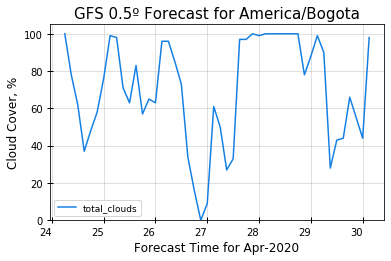

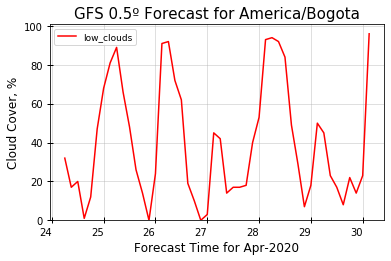

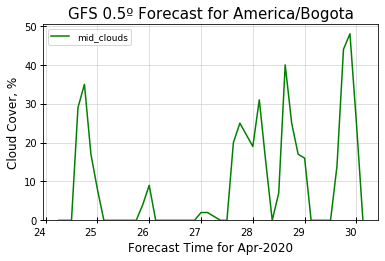

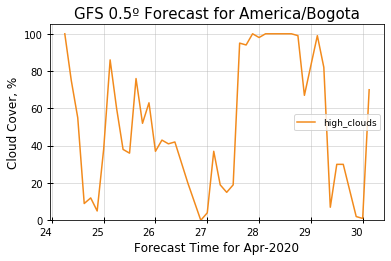

In [7]:
# Plot cloud cover percentages
cloud_vars = ['total_clouds', 'low_clouds','mid_clouds', 'high_clouds']

plt.style.use('fast')

# Figure 1
fig1, ax1 = plt.subplots();
ax1.tick_params(direction='inout', length=6, width=1, grid_alpha=0.5)

data_weatherforecast['total_clouds'].plot(label='total_clouds', color='#1580E4');

plt.rc('font', family='Helvetica')

plt.title('GFS 0.5º Forecast for {}'.format(tz), fontname="Helvetica", fontsize=15);
plt.ylabel('Cloud Cover, %', fontname="Helvetica", fontsize=12);
plt.xlabel('Forecast Time for {}-{}'.format(start.strftime("%b"), start.year), fontname="Helvetica", fontsize=12);

plt.gcf().autofmt_xdate();
date_format = mpl_dates.DateFormatter('%d');
plt.gca().xaxis.set_major_formatter(date_format);

plt.xticks(rotation=0)
plt.ylim(0, None)
plt.grid(True);
#plt.legent(loc="upper left", bbox_to_anchor=(1,1), fontsize=9) #Legend outside the box
plt.legend(fontsize=9);
plt.tight_layout;
plt.savefig('Total_Clouds.eps')

# Figure 2
fig2, ax2 = plt.subplots();
ax2.tick_params(direction='inout', length=6, width=1, grid_alpha=0.5)

data_weatherforecast['low_clouds'].plot(label='low_clouds',color='red');

plt.rc('font', family='Helvetica')

plt.title('GFS 0.5º Forecast for {}'.format(tz), fontname="Helvetica", fontsize=15);
plt.ylabel('Cloud Cover, %', fontname="Helvetica", fontsize=12);
plt.xlabel('Forecast Time for {}-{}'.format(start.strftime("%b"), start.year), fontname="Helvetica", fontsize=12);

plt.gcf().autofmt_xdate();
date_format = mpl_dates.DateFormatter('%d');
plt.gca().xaxis.set_major_formatter(date_format);

plt.xticks(rotation=0)
plt.ylim(0, None)
plt.grid(True);
plt.legend(fontsize=9);
plt.tight_layout;
plt.savefig('Low_Clouds.eps')

# Figure 3
fig3, ax3 = plt.subplots();
ax3.tick_params(direction='inout', length=6, width=1, grid_alpha=0.5)

data_weatherforecast['mid_clouds'].plot(label='mid_clouds',color='green');

plt.rc('font', family='Helvetica')

plt.title('GFS 0.5º Forecast for {}'.format(tz), fontname="Helvetica", fontsize=15);
plt.ylabel('Cloud Cover, %', fontname="Helvetica", fontsize=12);
plt.xlabel('Forecast Time for {}-{}'.format(start.strftime("%b"), start.year), fontname="Helvetica", fontsize=12);

plt.gcf().autofmt_xdate();
date_format = mpl_dates.DateFormatter('%d');
plt.gca().xaxis.set_major_formatter(date_format);

plt.xticks(rotation=0)
plt.ylim(0, None)
plt.grid(True);
plt.legend(fontsize=9);
plt.tight_layout;
plt.savefig('Mid_Clouds.eps')

# Figure 4
fig4, ax4 = plt.subplots();
ax4.tick_params(direction='inout', length=6, width=1, grid_alpha=0.5)

data_weatherforecast['high_clouds'].plot(label='high_clouds',color='#F28A1C');

plt.rc('font', family='Helvetica')

plt.title('GFS 0.5º Forecast for {}'.format(tz), fontname="Helvetica", fontsize=15);
plt.ylabel('Cloud Cover, %', fontname="Helvetica", fontsize=12);
plt.xlabel('Forecast Time for {}-{}'.format(start.strftime("%b"), start.year), fontname="Helvetica", fontsize=12);

plt.gcf().autofmt_xdate();
date_format = mpl_dates.DateFormatter('%d');
plt.gca().xaxis.set_major_formatter(date_format);

plt.xticks(rotation=0)
plt.ylim(0, None)
plt.grid(True);
plt.legend(fontsize=9);
plt.tight_layout;
plt.savefig('High_Clouds.eps')

### 2.2. IRRADIANCE FORECAST

As the reader can see, the forecast models provides irradiance data. However, many of forecast models do not include radiation components in their output fields, or if they do then the radiation fields suffer from poor solar position or radiative transfer algorithms. In order to improve this setback, it is often more accurate to create empirically derived radiation forecasts from the weather models' cloud cover forecasts.

PVLIB-Python provides two basic ways to convert cloud cover forecasts to irradiance forecasts. One method assumes a linear relationship between cloud cover and GHI, applies the scaling to a clear sky climatology, and then uses the DISC model to calculate DNI. The second method assumes a linear relationship between cloud cover and atmospheric transmittance, and then uses the *Liu-Jordan* model to calculate GHI, DNI, and DHI. Clear sky scaling of climatological GHI is also used in *Larson et. al*.

**Note:** Irradiance data is compared with the satellite data from **Meteocontrol**, the photovoltaic monitoring system arranged at the *Los Andes University*.

##### 2.2.1. Empirical Derivation of Irradiance Forecast by Larson et. al. Model

In [8]:
#Location
location = Location(latitude,longitude,tz,altitude=2624)
pressure = pvlib.atmosphere.alt2pres(altitude=2624) #Theorethical pressure is 560 mmHg (75 660.5 Pa)

# Irradiance Data
irrads_larson = fm.cloud_cover_to_irradiance(data_weatherforecast['total_clouds'], how='clearsky_scaling');
data_weatherforecast.to_csv('irrads_larson.csv')
irrads_larson.head();
diff = irrads_larson - data_weatherforecast[['ghi', 'dni', 'dhi']];
diff.head() #The irradiance forecast method by Larson et. al. is the same as the get_processed_data() function

,ghi,dni,dhi
2020-04-24 06:00:00-05:00,0.0,0.0,0.0
2020-04-24 09:00:00-05:00,0.0,0.0,0.0
2020-04-24 12:00:00-05:00,0.0,0.0,0.0
2020-04-24 15:00:00-05:00,0.0,0.0,0.0
2020-04-24 18:00:00-05:00,0.0,0.0,0.0


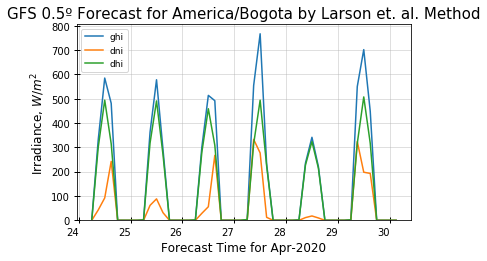

In [9]:
# Plot Irradiance Larson et. al. Method
plt.style.use('fast')

irrads_larson.plot();

plt.rc('font', family='Helvetica')

plt.title('GFS 0.5º Forecast for {} by Larson et. al. Method'.format(tz), fontname="Helvetica", fontsize=15);
plt.ylabel('Irradiance, $W/m^2$', fontname="Helvetica", fontsize=12);
plt.xlabel('Forecast Time for {}-{}'.format(start.strftime("%b"), start.year), fontname="Helvetica", fontsize=12);

plt.gcf().autofmt_xdate();
date_format = mpl_dates.DateFormatter('%d');
plt.gca().xaxis.set_major_formatter(date_format);

plt.tick_params(direction='inout', length=6, width=1, grid_alpha=0.5)

plt.xticks(rotation=0)
plt.ylim(0, None)
plt.grid(True);
plt.legend(fontsize=9);
plt.tight_layout;
plt.savefig('Irradiance_Larson.eps')

##### 2.2.2. Empirical Derivation of Irradiance Forecast by Liu-Jordan Model

In [10]:
# Irradiance Data
irrads_liujordan = fm.cloud_cover_to_irradiance(data_weatherforecast['total_clouds'], how='liujordan');
data_weatherforecast.to_csv('irrads_liujordan.csv');
irrads_liujordan.head()

,ghi,dni,dhi
2020-04-24 06:00:00-05:00,18.839326,0.000000e+00,18.839326
2020-04-24 09:00:00-05:00,348.332682,1.113794e+02,267.964439
2020-04-24 12:00:00-05:00,662.487119,3.791405e+02,287.695421
2020-04-24 15:00:00-05:00,496.657953,4.539430e+02,184.625835
2020-04-24 18:00:00-05:00,1.368139,5.590575e-12,1.368139


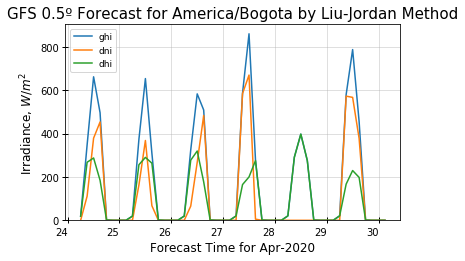

In [11]:
# Plot Irradiance Liu-Jordan Method
plt.style.use('fast')

irrads_liujordan.plot();

plt.rc('font', family='Helvetica')

plt.title('GFS 0.5º Forecast for {} by Liu-Jordan Method'.format(tz), fontname="Helvetica", fontsize=15);
plt.ylabel('Irradiance, $W/m^2$', fontname="Helvetica", fontsize=12);
plt.xlabel('Forecast Time for {}-{}'.format(start.strftime("%b"), start.year), fontname="Helvetica", fontsize=12);

plt.gcf().autofmt_xdate();
date_format = mpl_dates.DateFormatter('%d');
plt.gca().xaxis.set_major_formatter(date_format);

plt.tick_params(direction='inout', length=6, width=1, grid_alpha=0.5)

plt.xticks(rotation=0)
plt.ylim(0, None)
plt.grid(True);
plt.legend(fontsize=9);
plt.tight_layout;
plt.savefig('Irradiance_LiuJordan.eps')

##### 2.2.3.1. GHI Comparison between Larson et. al. Model and Liu-Jordan Model

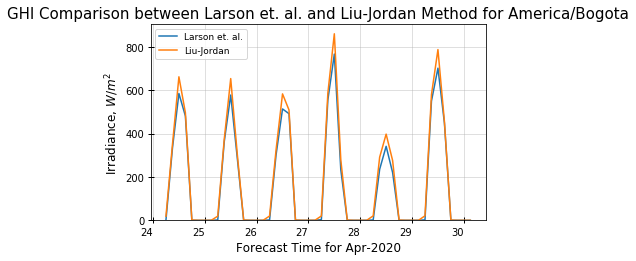

In [12]:
# GHI Comparison Plot

plt.style.use('fast')

irrads_larson['ghi'].plot(label='Larson et. al.');
irrads_liujordan['ghi'].plot(label='Liu-Jordan');

plt.rc('font', family='Helvetica')

plt.title('GHI Comparison between Larson et. al. and Liu-Jordan Method for {}'.format(tz), fontname="Helvetica", fontsize=15);
plt.ylabel('Irradiance, $W/m^2$', fontname="Helvetica", fontsize=12);
plt.xlabel('Forecast Time for {}-{}'.format(start.strftime("%b"), start.year), fontname="Helvetica", fontsize=12);

plt.gcf().autofmt_xdate();
date_format = mpl_dates.DateFormatter('%d');
plt.gca().xaxis.set_major_formatter(date_format);

plt.tick_params(direction='inout', length=6, width=1, grid_alpha=0.5)

plt.xticks(rotation=0)
plt.ylim(0, None)
plt.grid(True);
plt.legend(fontsize=9);
plt.tight_layout;
plt.savefig('Irradiance_Comparison_GHI.eps')

In [13]:
GHI_dif = irrads_larson['ghi'] - irrads_liujordan['ghi'];
GHI_dif.head()

2020-04-24 06:00:00-05:00   -17.544984
2020-04-24 09:00:00-05:00   -16.491815
2020-04-24 12:00:00-05:00   -77.160873
2020-04-24 15:00:00-05:00   -15.119868
2020-04-24 18:00:00-05:00    -1.359730
Name: ghi, dtype: float64

##### 2.2.3.2. DNI Comparison between Larson et. al. Model and Liu-Jorsan Model

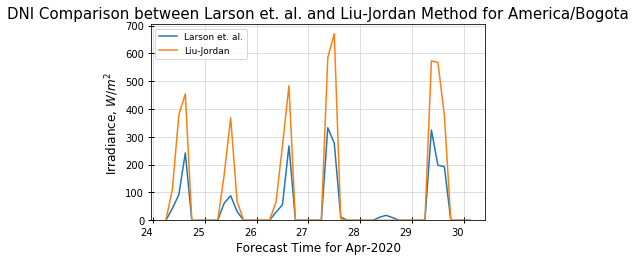

In [14]:
# DNI Comparison Plot

plt.style.use('fast')

irrads_larson['dni'].plot(label='Larson et. al.');
irrads_liujordan['dni'].plot(label='Liu-Jordan');

plt.rc('font', family='Helvetica')

plt.title('DNI Comparison between Larson et. al. and Liu-Jordan Method for {}'.format(tz), fontname="Helvetica", fontsize=15);
plt.ylabel('Irradiance, $W/m^2$', fontname="Helvetica", fontsize=12);
plt.xlabel('Forecast Time for {}-{}'.format(start.strftime("%b"), start.year), fontname="Helvetica", fontsize=12);

plt.gcf().autofmt_xdate();
date_format = mpl_dates.DateFormatter('%d');
plt.gca().xaxis.set_major_formatter(date_format);

plt.tick_params(direction='inout', length=6, width=1, grid_alpha=0.5)

plt.xticks(rotation=0)
plt.ylim(0, None)
plt.grid(True);
plt.legend(loc="upper left", fontsize=9);
plt.tight_layout;
plt.savefig('Irradiance_Comparison_DNI.eps')

In [15]:
DNI_dif = irrads_larson['dni'] - irrads_liujordan['dni'];
DNI_dif.head()

2020-04-24 06:00:00-05:00    0.000000e+00
2020-04-24 09:00:00-05:00   -6.877900e+01
2020-04-24 12:00:00-05:00   -2.871422e+02
2020-04-24 15:00:00-05:00   -2.116482e+02
2020-04-24 18:00:00-05:00   -5.590575e-12
Name: dni, dtype: float64

##### 2.2.3.2. DHI Comparison between Larson et. al. Model and Liu-Jorsan Model

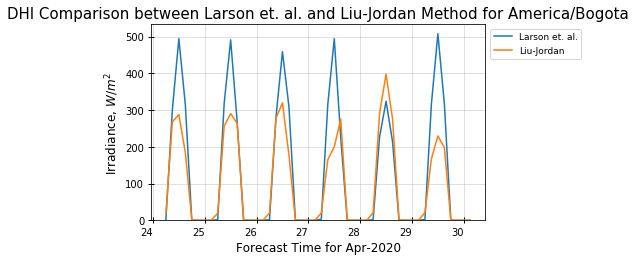

In [16]:
# DHI Comparison Plot

plt.style.use('fast')

irrads_larson['dhi'].plot(label='Larson et. al.');
irrads_liujordan['dhi'].plot(label='Liu-Jordan');

plt.rc('font', family='Helvetica')

plt.title('DHI Comparison between Larson et. al. and Liu-Jordan Method for {}'.format(tz), fontname="Helvetica", fontsize=15);
plt.ylabel('Irradiance, $W/m^2$', fontname="Helvetica", fontsize=12);
plt.xlabel('Forecast Time for {}-{}'.format(start.strftime("%b"), start.year), fontname="Helvetica", fontsize=12);

plt.gcf().autofmt_xdate();
date_format = mpl_dates.DateFormatter('%d');
plt.gca().xaxis.set_major_formatter(date_format);

plt.tick_params(direction='inout', length=6, width=1, grid_alpha=0.5)

plt.xticks(rotation=0)
plt.ylim(0, None)
plt.grid(True);
plt.legend(loc="upper left", bbox_to_anchor=(1,1), fontsize=9);
plt.tight_layout;
plt.savefig('Irradiance_Comparison_DHI.eps')

In [17]:
DHI_dif = irrads_larson['dhi'] - irrads_liujordan['dhi'];
DHI_dif.head()

2020-04-24 06:00:00-05:00    -17.544984
2020-04-24 09:00:00-05:00     33.145504
2020-04-24 12:00:00-05:00    206.688367
2020-04-24 15:00:00-05:00    130.417841
2020-04-24 18:00:00-05:00     -1.359730
Name: dhi, dtype: float64

##### 2.2.3.3. Interpolation Test to Improve Resolution and Precision for Irradiance Data
Most weather model output has a fairly coarse time resolution, at least an hour. The irradiance forecasts have the same time resolution as the weather data. However, it is straightforward to interpolate the cloud cover forecasts onto a higher resolution time domain, and then recalculate the irradiance.

In [18]:
resampled_data = data_weatherforecast.resample('5min').interpolate()

resampled_irrads = fm.cloud_cover_to_irradiance(resampled_data['total_clouds'], how='clearsky_scaling') #Larson Method

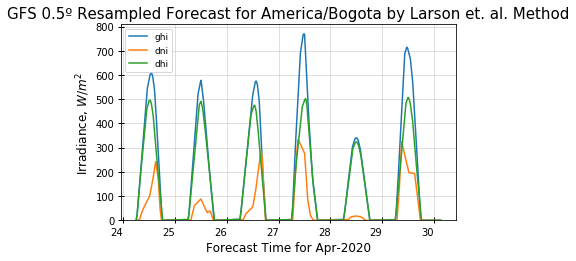

In [19]:
plt.style.use('fast')

resampled_irrads.plot();

plt.rc('font', family='Helvetica')

plt.title('GFS 0.5º Resampled Forecast for {} by Larson et. al. Method'.format(tz), fontname="Helvetica", fontsize=15);
plt.ylabel('Irradiance, $W/m^2$', fontname="Helvetica", fontsize=12);
plt.xlabel('Forecast Time for {}-{}'.format(start.strftime("%b"), start.year), fontname="Helvetica", fontsize=12);

plt.gcf().autofmt_xdate();
date_format = mpl_dates.DateFormatter('%d');
plt.gca().xaxis.set_major_formatter(date_format);

plt.tick_params(direction='inout', length=6, width=1, grid_alpha=0.5)

plt.xticks(rotation=0)
plt.ylim(0, None)
plt.grid(True);
plt.legend(fontsize=9);
plt.tight_layout;
plt.savefig('Resampled_Irradiance_Larson.eps')

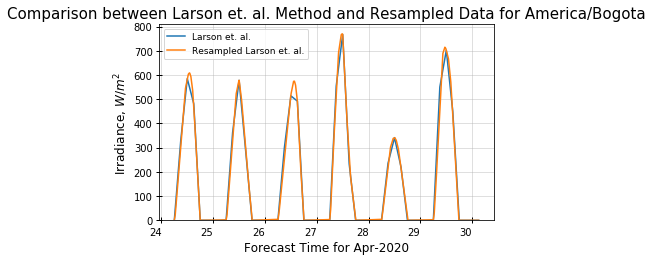

In [20]:
# Irradiance Resolution Comparison Plot

plt.style.use('fast')

irrads_larson['ghi'].plot(label='Larson et. al.');
resampled_irrads['ghi'].plot(label='Resampled Larson et. al.');

plt.rc('font', family='Helvetica')

plt.title('Comparison between Larson et. al. Method and Resampled Data for {}'.format(tz), fontname="Helvetica", fontsize=15);
plt.ylabel('Irradiance, $W/m^2$', fontname="Helvetica", fontsize=12);
plt.xlabel('Forecast Time for {}-{}'.format(start.strftime("%b"), start.year), fontname="Helvetica", fontsize=12);

plt.gcf().autofmt_xdate();
date_format = mpl_dates.DateFormatter('%d');
plt.gca().xaxis.set_major_formatter(date_format);

plt.tick_params(direction='inout', length=6, width=1, grid_alpha=0.5)

plt.xticks(rotation=0)
plt.ylim(0, None)
plt.grid(True);
plt.legend(fontsize=9);
plt.tight_layout;
plt.savefig('Irradiance_Comparison_Resampled.eps')

___
## PART 3: WEATHER MODELS

### 3.1. PVLIB-PYTHON THREDDS UNIDATA LIBRARY
According to Sandia' PVLIB-Python, these are the main weatehr models availaby at the THREDDS Unidata Library.

##### 3.1.1. GFS
The Global Forecast System (GFS) is the US model that provides forecasts for the entire globe. The GFS is updated every 6 hours. The GFS is run at two resolutions, 0.25 deg and 0.5 deg, and is available with 3 hour time resolution. Forecasts from GFS model were shown above. **Use the GFS, among others, if you want forecasts for 1-7 days or if you want forecasts for anywhere on Earth**.

##### 3.1.2. HRRR
The High Resolution Rapid Refresh (HRRR) model is perhaps the most accurate model, however, it is only available for ~15 hours. It is updated every hour and runs at 3 km resolution. The HRRR excels in severe weather situations. See the NOAA ESRL HRRR page for more information. **Use the HRRR, among others, if you want forecasts for less than 24 hours. The HRRR model covers the continental United States**.

##### 3.1.3 RAP
The Rapid Refresh (RAP) model is the parent model for the HRRR. It is updated every hour and runs at 40, 20, and 13 km resolutions. Only the 20 and 40 km resolutions are currently available in PVLIB-Python. It is also excels in severe weather situations. See the NOAA ESRL HRRR page for more information. **Use the RAP, among others, if you want forecasts for less than 24 hours. The RAP model covers most of North America**.

##### 3.1.4. NAM
The North American Mesoscale model covers, not surprisingly, North America. It is updated every 6 hours. PVLIB-Python provides access to 20 km resolution NAM data with **a time horizon of up to 4 days**.

##### 3.1.5. NDFD
The National Digital Forecast Database is not a model, but rather a collection of forecasts made by National Weather Service offices across the country. It is updated every 6 hours. **Use the NDFD, among others, for forecasts at all time horizons. The NDFD is available for the United States**.

### 3.2. TMY METEOROLOGICAL DATA

### 3.3. METEOBLUE METEOROLOGICAL DATA
___

___
## PART 4: CALCULATING MODELING INTERMEDIATES

Before we can calculate power for all the forecast times, we will need to calculate:

1. Solar position.
2. Extra terrestrial radiation.
3. Airmass.
4. Angle of incidence.
5. POA sky and ground diffuse radiation.
6. Cell and module temperatures.

**RELEVANT**: It is important to notice that the easiest way to obtain a time series of clear sky irradiance is to use a ```Location``` object’s ```get_clearsky()``` method. The ```get_clearsky()``` method does the dirty work of calculating **solar position**, **extraterrestrial irradiance**, **airmass**, and **atmospheric pressure**, as appropriate, leaving the user to only specify the most important parameters: **time** and **atmospheric attenuation**.

Before all, is relevant to take into account the **turbidity**. Sandia' PVLIB-Python includes a file with monthly climatological turbidity values for the globe. The code below creates turbidity maps for a few months of the year.

More info at https://pvlib-python.readthedocs.io/en/latest/clearsky.html.

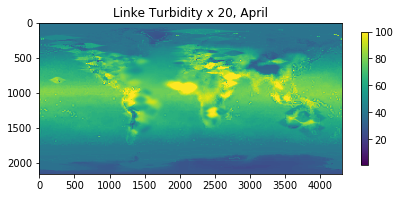

In [21]:
import calendar
import tables

pvlib_path = os.path.dirname(os.path.abspath(pvlib.clearsky.__file__));

filepath = os.path.join(pvlib_path, 'data', 'LinkeTurbidities.h5');

def plot_turbidity_map(month, vmin=1, vmax=100):
     plt.figure();
     with tables.open_file(filepath) as lt_h5_file:
         ltdata = lt_h5_file.root.LinkeTurbidity[:, :, month-1]
     plt.imshow(ltdata, vmin=vmin, vmax=vmax);
     # Data is in units of 20 x turbidity
     plt.title('Linke Turbidity x 20, ' + calendar.month_name[month]);
     plt.colorbar(shrink=0.5);
     plt.tight_layout();
 
plot_turbidity_map(4)

### 4.1. SOLAR POSITION
The default solar position algorithm is based on **Reda and Andreas (2004)**. The implementation here is pretty 'fast', but the reader can make it even faster installing ```numba``` and using the add ```method='nrel_numba'``` to the function call.

More info at https://pvlib-python.readthedocs.io/en/stable/generated/pvlib.solarposition.get_solarposition.html.

In [22]:
# Retrieve time and location parameters
time = data_weatherforecast.index;
a_point = fm.location;

solpos = a_point.get_solarposition(time);
solpos.head()

,apparent_zenith,zenith,apparent_elevation,elevation,azimuth,equation_of_time
2020-04-24 06:00:00-05:00,87.332340,87.588606,2.667660,2.411394,77.049651,1.924130
2020-04-24 09:00:00-05:00,43.815568,43.831712,46.184432,46.168288,75.796456,1.945719
2020-04-24 12:00:00-05:00,8.686358,8.688910,81.313642,81.311090,350.785767,1.967184
2020-04-24 15:00:00-05:00,46.576793,46.594565,43.423207,43.405435,283.862947,1.988525
2020-04-24 18:00:00-05:00,89.806340,90.339395,0.193660,-0.339395,283.329788,2.009741


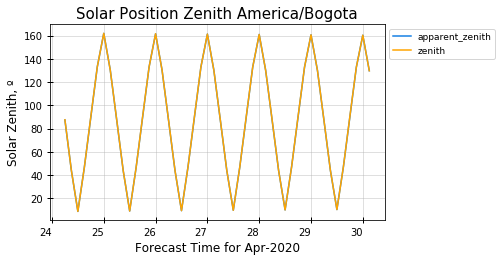

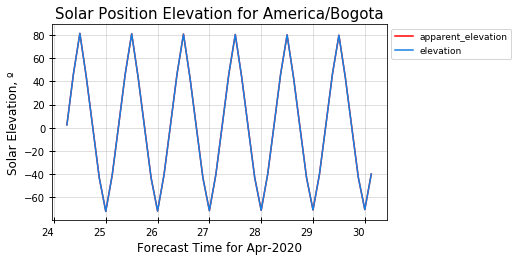

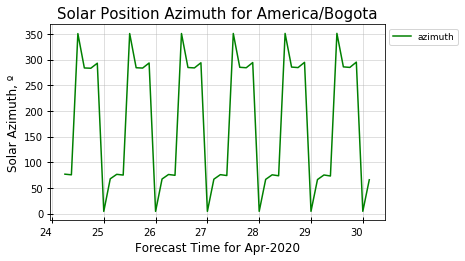

In [23]:
# Plot cloud cover percentages
solpos_vars = ['apparent_zenith', 'zenith','apparent_elevation', 'elevation', 'azimuth', 'equation_of_time']

plt.style.use('fast')

# Figure 1
fig1, ax1 = plt.subplots();

solpos['apparent_zenith'].plot(label='apparent_zenith', color='#1580E4');
solpos['zenith'].plot(label='zenith', color='orange');

plt.rc('font', family='Helvetica')

plt.title('Solar Position Zenith {}'.format(tz), fontname="Helvetica", fontsize=15);
plt.ylabel('Solar Zenith, º', fontname="Helvetica", fontsize=12);
plt.xlabel('Forecast Time for {}-{}'.format(start.strftime("%b"), start.year), fontname="Helvetica", fontsize=12);

plt.gcf().autofmt_xdate();
date_format = mpl_dates.DateFormatter('%d');
plt.gca().xaxis.set_major_formatter(date_format);

ax1.tick_params(direction='inout', length=6, width=1, grid_alpha=0.5)

plt.xticks(rotation=0)
plt.grid(True);
plt.legend(loc="upper left", bbox_to_anchor=(1,1), fontsize=9);
plt.tight_layout;
plt.savefig('SolPos_Zenith.eps')

# Figure 2
fig2, ax2 = plt.subplots();

solpos['apparent_elevation'].plot(label='apparent_elevation', color='red');
solpos['elevation'].plot(label='elevation', color='#1580E4');

plt.rc('font', family='Helvetica')

plt.title('Solar Position Elevation for {}'.format(tz), fontname="Helvetica", fontsize=15);
plt.ylabel('Solar Elevation, º', fontname="Helvetica", fontsize=12);
plt.xlabel('Forecast Time for {}-{}'.format(start.strftime("%b"), start.year), fontname="Helvetica", fontsize=12);

plt.gcf().autofmt_xdate();
date_format = mpl_dates.DateFormatter('%d');
plt.gca().xaxis.set_major_formatter(date_format);

ax2.tick_params(direction='inout', length=6, width=1, grid_alpha=0.5)

plt.xticks(rotation=0)
plt.grid(True);
plt.legend(loc="upper left", bbox_to_anchor=(1,1), fontsize=9);
plt.tight_layout;
plt.savefig('SolPos_Elevation.eps')

# Figure 3
fig3, ax3 = plt.subplots();

solpos['azimuth'].plot(label='azimuth', color='green');

plt.rc('font', family='Helvetica')

plt.title('Solar Position Azimuth for {}'.format(tz), fontname="Helvetica", fontsize=15);
plt.ylabel('Solar Azimuth, º', fontname="Helvetica", fontsize=12);
plt.xlabel('Forecast Time for {}-{}'.format(start.strftime("%b"), start.year), fontname="Helvetica", fontsize=12);

plt.gcf().autofmt_xdate();
date_format = mpl_dates.DateFormatter('%d');
plt.gca().xaxis.set_major_formatter(date_format);

ax3.tick_params(direction='inout', length=6, width=1, grid_alpha=0.5)

plt.xticks(rotation=0)
plt.grid(True);
plt.legend(loc="upper left", bbox_to_anchor=(1,1), fontsize=9);
plt.tight_layout;
plt.savefig('SolPos_Azimuth.eps')

### 4.2. EXTRATERRESTRIAL DNI

In order to determine many plane of array diffuse irradiance models, is needed to calculate the extra terrestrial radiation. To accomplish this, the ```irradiance``` class is used.

Many solar power algorithms start with the irradiance incident on the top of the Earth's atmosphere, often known as the extraterrestrial radiation. ```PVLIB-Python``` has four different algorithms to calculate the yearly cycle of the extraterrestrial radiation given the solar constant.

By default the method is **Spencer**.

##### 4.2.1. Extraterrestrial Methods Example
The user can also control the solar constant. Recent literature suggests that the solar constant is $1361 \: W/m^2$ rather than the commonly accepted $1367 \: W/m^2$.

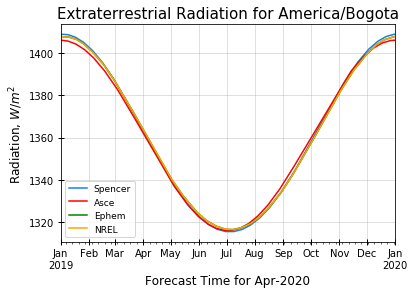

In [24]:
# Extraterrestrial Radiation Data (ETR at the code)

time = pd.date_range('2019-01-01', '2020-01-01')

etr_spencer = irradiance.get_extra_radiation(time, method='Spencer', solar_constant=1361);
etr_asce = irradiance.get_extra_radiation(time, method='Asce', solar_constant=1361);
etr_ephem = irradiance.get_extra_radiation(time, method='Pyephem', solar_constant=1361); 
etr_nrel = irradiance.get_extra_radiation(time, method='NREL', solar_constant=1361);

# Extraterrestrial Methods Example Plot
plt.style.use('fast')

# Figure 1
fig1, ax1 = plt.subplots();

etr_spencer.plot(label='Spencer', color='#1580E4');
etr_asce.plot(label='Asce', color='red');
etr_ephem.plot(label='Ephem', color='green');
etr_nrel.plot(label='NREL', color='orange');

plt.rc('font', family='Helvetica')

plt.title('Extraterrestrial Radiation for {}'.format(tz), fontname="Helvetica", fontsize=15);
plt.ylabel('Radiation, $W/m^2$', fontname="Helvetica", fontsize=12);
plt.xlabel('Forecast Time for {}-{}'.format(start.strftime("%b"), start.year), fontname="Helvetica", fontsize=12);

#plt.gcf().autofmt_xdate();
#date_format = mpl_dates.DateFormatter('%m');
#plt.gca().xaxis.set_major_formatter(date_format);

ax1.tick_params(direction='inout', length=6, width=1, grid_alpha=0.5)

plt.xticks(rotation=0)
plt.grid(True);
plt.legend(fontsize=9);
plt.tight_layout;
plt.savefig('ETR_MethodsExample.eps')

**The PyEphem and NREL methods are the most accurate**. However, as shown in the plot above, the difference between them and the Spencer method is only $\pm \: 2 \: W/m^2$ over the entire year (shown below).

##### 4.2.2. Extraterrestrial for Los Andes Analysis

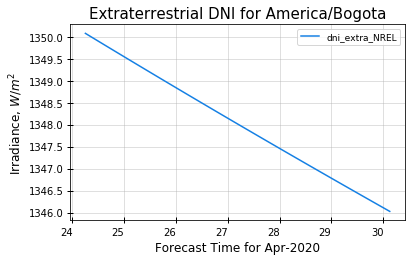

In [25]:
dni_extra = irradiance.get_extra_radiation(fm.time, method='NREL');

# Plot Extraterrestrial DNI
plt.style.use('fast')

# Figure 1
fig1, ax1 = plt.subplots();
ax1.tick_params(direction='inout', length=6, width=1, grid_alpha=0.5)

dni_extra.plot(label='dni_extra_NREL', color='#1580E4');

plt.rc('font', family='Helvetica')

plt.title('Extraterrestrial DNI for {}'.format(tz), fontname="Helvetica", fontsize=15);
plt.ylabel('Irradiance, $W/m^2$', fontname="Helvetica", fontsize=12);
plt.xlabel('Forecast Time for {}-{}'.format(start.strftime("%b"), start.year), fontname="Helvetica", fontsize=12);

plt.gcf().autofmt_xdate();
date_format = mpl_dates.DateFormatter('%d');
plt.gca().xaxis.set_major_formatter(date_format);

plt.xticks(rotation=0)
plt.grid(True);
plt.legend(fontsize=9);
plt.tight_layout;
plt.savefig('SolPos_ETDNI.eps')

### 4.3. AIRMASS

Sandia disposes at PVLIB Atmosphere class a variety of models to get the airmass data. Some of the models are: (i.) **Simple**, (ii.) **Kasten 1966**, (iii.) **Young-Irvine 1967**, (iv.) **Kasten-Young 1989**, (v.) **Gueymard 1993**, **Young 1994** and **Pickering 2002**.

By default the model is **Kasten-Young 1989**.

More information of the model options at the Atmosphere Module Tutorial —https://nbviewer.jupyter.org/github/pvlib/pvlib-python/blob/master/docs/tutorials/atmosphere.ipynb.

##### 4.3.1. Relative Airmass

This module gives the relative (not pressure-corrected) airmass at sea-level when given a sun zenith angle (in degrees).

More info about the model at https://pvlib-python.readthedocs.io/en/stable/generated/pvlib.atmosphere.get_relative_airmass.html.

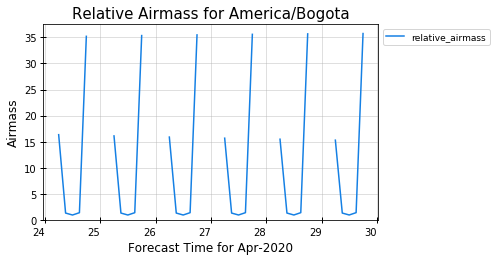

In [26]:
relative_airmass = atmosphere.get_relative_airmass(solpos['apparent_zenith'], model='kastenyoung1989');

# Plot Relative Airmass
plt.style.use('fast')

# Figure 1
fig1, ax1 = plt.subplots();

relative_airmass.plot(label='relative_airmass', color='#1580E4');

plt.rc('font', family='Helvetica')

plt.title('Relative Airmass for {}'.format(tz), fontname="Helvetica", fontsize=15);
plt.ylabel('Airmass', fontname="Helvetica", fontsize=12);
plt.xlabel('Forecast Time for {}-{}'.format(start.strftime("%b"), start.year), fontname="Helvetica", fontsize=12);

plt.gcf().autofmt_xdate();
date_format = mpl_dates.DateFormatter('%d');
plt.gca().xaxis.set_major_formatter(date_format);

ax1.tick_params(direction='inout', length=6, width=1, grid_alpha=0.5)

plt.xticks(rotation=0)
plt.ylim(0, None)
plt.grid(True);
plt.legend(loc="upper left", bbox_to_anchor=(1,1), fontsize=9);
plt.tight_layout;
plt.savefig('Relative_Airmass.eps')

##### 4.3.2. Absolute Airmass

This module determines absolute (pressure corrected) airmass from relative airmass and pressure.

Gives the airmass for locations not at sea-level (i.e. not at standard pressure). The input argument 'AMrelative' is the relative airmass. The input argument 'pressure' is the pressure (in Pascals) at the location of interest and must be greater than 0. The calculation for absolute airmass is:

$$ Absolute\_Airmass = Relative\_Airmass * \frac{Pressure}{101325}$$

More info about the model at https://pvlib-python.readthedocs.io/en/stable/generated/pvlib.atmosphere.get_absolute_airmass.html.

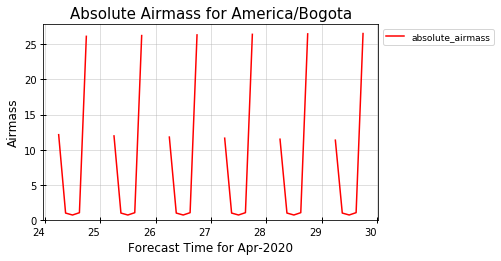

In [27]:
pressure = 75160 #Pressute at Pa according to IDEAM —(p. 26 - 27) http://www.ideam.gov.co/documents/21021/21135/CARACTERIZACION+CLIMATICA+BOGOTA.pdf/d7e42ed8-a6ef-4a62-b38f-f36f58db29aa

absolute_airmass = atmosphere.get_absolute_airmass(relative_airmass,pressure);

# Plot Absolute Airmass
plt.style.use('fast')

# Figure 1
fig1, ax1 = plt.subplots();

absolute_airmass.plot(label='absolute_airmass', color='red');

plt.rc('font', family='Helvetica')

plt.title('Absolute Airmass for {}'.format(tz), fontname="Helvetica", fontsize=15);
plt.ylabel('Airmass', fontname="Helvetica", fontsize=12);
plt.xlabel('Forecast Time for {}-{}'.format(start.strftime("%b"), start.year), fontname="Helvetica", fontsize=12);

plt.gcf().autofmt_xdate();
date_format = mpl_dates.DateFormatter('%d');
plt.gca().xaxis.set_major_formatter(date_format);

ax1.tick_params(direction='inout', length=6, width=1, grid_alpha=0.5)

plt.xticks(rotation=0)
plt.ylim(0, None)
plt.grid(True);
plt.legend(loc="upper left", bbox_to_anchor=(1,1), fontsize=9);
plt.tight_layout;
plt.savefig('Absolute_Airmass.eps')

##### 4.3.3. Some Others Airmass Models Example

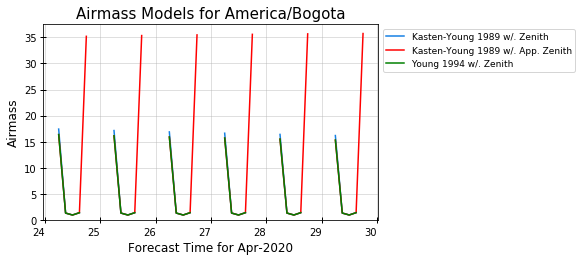

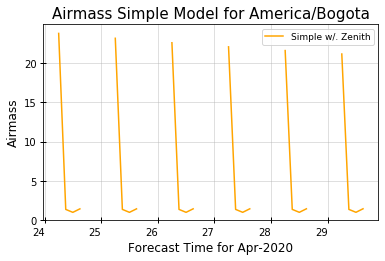

In [28]:
#Kasten-Young 1989 Model with Zenith Variable
airmass_zenith_kastenyoung = atmosphere.get_relative_airmass(solpos['zenith'])

#Kasten-Young 1989 Model with Apparent Zenith Variable
airmass_apparentzenith_kastenyoung = atmosphere.get_relative_airmass(solpos['apparent_zenith'])

#Young 1994 Model with Zenith Variable
airmass_zenith_young = atmosphere.get_relative_airmass(solpos['zenith'], model='young1994')

#Simple Model with Zenith Variable
airmass_zenith_simple = atmosphere.get_relative_airmass(solpos['zenith'], model='simple')

plt.style.use('fast')

# Figure 1
fig1, ax1 = plt.subplots();

airmass_zenith_kastenyoung.plot(label='Kasten-Young 1989 w/. Zenith', color='#1580E4');
airmass_apparentzenith_kastenyoung.plot(label='Kasten-Young 1989 w/. App. Zenith', color='red');
airmass_zenith_young.plot(label='Young 1994 w/. Zenith', color='green');

plt.rc('font', family='Helvetica')

plt.title('Airmass Models for {}'.format(tz), fontname="Helvetica", fontsize=15);
plt.ylabel('Airmass', fontname="Helvetica", fontsize=12);
plt.xlabel('Forecast Time for {}-{}'.format(start.strftime("%b"), start.year), fontname="Helvetica", fontsize=12);

plt.gcf().autofmt_xdate();
date_format = mpl_dates.DateFormatter('%d');
plt.gca().xaxis.set_major_formatter(date_format);

ax1.tick_params(direction='inout', length=6, width=1, grid_alpha=0.5)

plt.xticks(rotation=0)
plt.ylim(0, None)
plt.grid(True);
plt.legend(loc="upper left", bbox_to_anchor=(1,1), fontsize=9);
plt.tight_layout;
plt.savefig('Airmass_Models.eps')

# Figure 2
fig2, ax2 = plt.subplots();

airmass_zenith_simple.plot(label='Simple w/. Zenith', color='orange');

plt.rc('font', family='Helvetica')

plt.title('Airmass Simple Model for {}'.format(tz), fontname="Helvetica", fontsize=15);
plt.ylabel('Airmass', fontname="Helvetica", fontsize=12);
plt.xlabel('Forecast Time for {}-{}'.format(start.strftime("%b"), start.year), fontname="Helvetica", fontsize=12);

plt.gcf().autofmt_xdate();
date_format = mpl_dates.DateFormatter('%d');
plt.gca().xaxis.set_major_formatter(date_format);

ax2.tick_params(direction='inout', length=6, width=1, grid_alpha=0.5)

plt.xticks(rotation=0)
plt.ylim(0, None)
plt.grid(True);
plt.legend(fontsize=9);
plt.tight_layout;
plt.savefig('Airmass_SimpleModel.eps')

### 4.4. PLANE OF ARRAY (POA)

Sandia disposes at PVLIB Atmosphere class a variety of models to get the airmass data. Some of the models are: (i.) **Simple**, (ii.) **Kasten 1966**, (iii.) **Young-Irvine 1967**, (iv.) **Kasten-Young 1989**, (v.) **Gueymard 1993**, **Young 1994** and **Pickering 2002**.

By default the model is **Kasten-Young 1989**.

More info at https://pvlib-python.readthedocs.io/en/stable/api.html#irradiance.

More info about the model at https://nbviewer.jupyter.org/github/pvlib/pvlib-python/blob/master/docs/tutorials/irradiance.ipynb.

##### 4.4.1. POA Sky Diffuse

Sandia disposes at PVLIB Irradiance class a variety of models to get the POA data. Some of the models are: (i.) **Perez**, (ii.) **Hay-Davies 1980**, (iii.) **Klucher-1979**, (iv.) **Reindl-1990** and (v.) **King**.

More info at https://pvlib-python.readthedocs.io/en/stable/api.html#transposition-models.

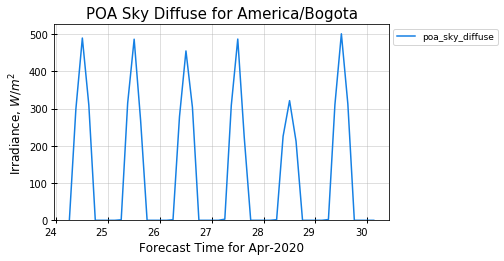

In [29]:
surface_tilt = 10;
surface_azimuth = 180; #Fixed south oriented

poa_sky_diffuse = irradiance.haydavies(surface_tilt, surface_azimuth,
                                       data_weatherforecast['dhi'], data_weatherforecast['dni'], dni_extra,
                                       solpos['apparent_zenith'], solpos['azimuth']);

# POA Sky Diffuse Plot

plt.style.use('fast')

fig1, ax1 = plt.subplots();

poa_sky_diffuse.plot(label='poa_sky_diffuse', color='#1580E4');

plt.rc('font', family='Helvetica')

plt.title('POA Sky Diffuse for {}'.format(tz), fontname="Helvetica", fontsize=15);
plt.ylabel('Irradiance, $W/m^2$', fontname="Helvetica", fontsize=12);
plt.xlabel('Forecast Time for {}-{}'.format(start.strftime("%b"), start.year), fontname="Helvetica", fontsize=12);

plt.gcf().autofmt_xdate();
date_format = mpl_dates.DateFormatter('%d');
plt.gca().xaxis.set_major_formatter(date_format);

ax1.tick_params(direction='inout', length=6, width=1, grid_alpha=0.5)

plt.xticks(rotation=0)
plt.ylim(0, None)
plt.grid(True);
plt.legend(loc="upper left", bbox_to_anchor=(1,1), fontsize=9);
plt.tight_layout;
plt.savefig('POA_Sky_Diffuse.eps')

##### 4.4.2. POA Ground Diffuse

Calculate ground diffuse. We specified the albedo above. You could have also provided a string to the surface_type keyword argument.

More info at https://pvlib-python.readthedocs.io/en/stable/api.html#transposition-models.

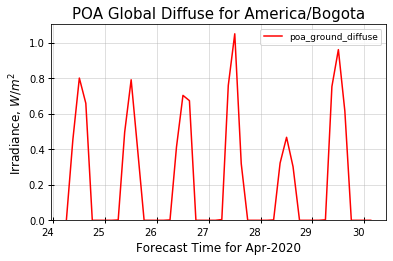

In [30]:
surface_albedo = irradiance.SURFACE_ALBEDOS['urban']; # Check the surfaces albedo list with print(irradiance.SURFACE_ALBEDOS.items()) function

poa_ground_diffuse = irradiance.get_ground_diffuse(surface_tilt, irrads_larson['ghi'], albedo=surface_albedo);

# POA Ground Diffuse Plot

plt.style.use('fast')

fig1, ax1 = plt.subplots();

poa_ground_diffuse.plot(label='poa_ground_diffuse', color='red');

plt.rc('font', family='Helvetica')

plt.title('POA Global Diffuse for {}'.format(tz), fontname="Helvetica", fontsize=15);
plt.ylabel('Irradiance, $W/m^2$', fontname="Helvetica", fontsize=12);
plt.xlabel('Forecast Time for {}-{}'.format(start.strftime("%b"), start.year), fontname="Helvetica", fontsize=12);

plt.gcf().autofmt_xdate();
date_format = mpl_dates.DateFormatter('%d');
plt.gca().xaxis.set_major_formatter(date_format);

ax1.tick_params(direction='inout', length=6, width=1, grid_alpha=0.5)

plt.xticks(rotation=0)
plt.ylim(0, None)
plt.grid(True);
plt.legend(fontsize=9);
plt.tight_layout;
plt.savefig('POA_Global_Diffuse.eps')

### 4.5. ANGLE OF INCIDENCE (AOI)

Calculates the angle of incidence of the solar vector on a surface. This is the angle between the solar vector and the surface normal. **Input all angles in degrees**.

More info at https://pvlib-python.readthedocs.io/en/stable/generated/pvlib.irradiance.aoi.html.

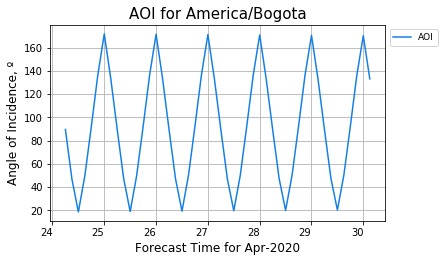

In [31]:
aoi = irradiance.aoi(surface_tilt, surface_azimuth, solpos['apparent_zenith'], solpos['azimuth']);

# AOI Plot

plt.style.use('fast')

fig1, ax1 = plt.subplots();

aoi.plot(label='AOI', color='#1580E4');

plt.rc('font', family='Helvetica')

plt.title('AOI for {}'.format(tz), fontname="Helvetica", fontsize=15);
plt.ylabel('Angle of Incidence, º', fontname="Helvetica", fontsize=12);
plt.xlabel('Forecast Time for {}-{}'.format(start.strftime("%b"), start.year), fontname="Helvetica", fontsize=12);

plt.gcf().autofmt_xdate();
date_format = mpl_dates.DateFormatter('%d');
plt.gca().xaxis.set_major_formatter(date_format);

ax2.tick_params(direction='inout', length=6, width=1, grid_alpha=0.5)

plt.xticks(rotation=0)
plt.grid(True);
plt.legend(loc="upper left", bbox_to_anchor=(1,1), fontsize=9);
plt.tight_layout;
plt.savefig('AOI.eps')

### 4.6. TOTAL POA

Determine in-plane irradiance components. Combines DNI with sky diffuse and ground-reflected irradiance to calculate total, direct and diffuse irradiance components **<ins>in</ins>** the plane of array.

More info of the function at (i.) https://pvlib-python.readthedocs.io/en/stable/generated/pvlib.irradiance.poa_components.html and (ii.) https://pvpmc.sandia.gov/modeling-steps/1-weather-design-inputs/plane-of-array-poa-irradiance/.

An extract from the second page snipped above makes clear that one can measure the plane of array irradiance directly with a pyranometer, reference cell or reference module mounted in the same orientation of the array. **<ins>However</ins>**, the analyst must understand the different characteristics of these sensors to ensure that any subsequent corrections made to the measured POA irradiance are appropriate.  For example, a matched reference cell or module probably has the same reflective properties of the modules in the array, so reflective losses are inherently included in the measured value and should not be *'corrected'* for again.

More info about plane of array (POA) at https://www.campbellsci.cc/blog/albedo-resource-assessment.

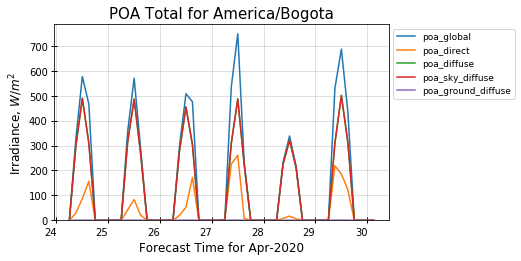

In [32]:
poa_irrad = irradiance.poa_components(aoi, data_weatherforecast['dni'], poa_sky_diffuse, poa_ground_diffuse);

# Total POA Plot

plt.style.use('fast')

poa_irrad.plot(label='poa_irrad');

plt.rc('font', family='Helvetica')

plt.title('POA Total for {}'.format(tz), fontname="Helvetica", fontsize=15);
plt.ylabel('Irradiance, $W/m^{2}$', fontname="Helvetica", fontsize=12);
plt.xlabel('Forecast Time for {}-{}'.format(start.strftime("%b"), start.year), fontname="Helvetica", fontsize=12);

plt.gcf().autofmt_xdate();
date_format = mpl_dates.DateFormatter('%d');
plt.gca().xaxis.set_major_formatter(date_format);

plt.tick_params(direction='inout', length=6, width=1, grid_alpha=0.5)

plt.xticks(rotation=0)
plt.ylim(0, None)
plt.grid(True);
plt.legend(loc="upper left", bbox_to_anchor=(1,1), fontsize=9);
plt.tight_layout;
plt.savefig('POA_Total.eps')

### 4.7. CELL AND MODULE TEMPERATURE

Estimate cell and module temperatures per the Sandia PV Array Performance Model (SAPM, SAND2004-3535), from the incident irradiance, wind speed, ambient temperature, and SAPM module parameters.

PV system efficiency can vary by up to 0.5% per ºC, so it is important to accurately model cell and module temperature. From King et. al. (2004):

$$T_{module} = E \: e^{a + b \: · \: WS} + T_a$$

$$T_{cell} = T_{module} + \frac{E}{E_0} · \Delta T$$

The $a$, $b$, and $\Delta T$ parameters depend on the module and racking type. **The default parameter set is ```open_rack_cell_glassback```**.

Notice that ```sapm_celltemp``` works with either scalar or vector inputs, but always returns a pandas DataFrame.


More info at https://wholmgren-pvlib-python-new.readthedocs.io/en/doc-reorg2/generated/pvsystem/pvlib.pvsystem.sapm_celltemp.html.

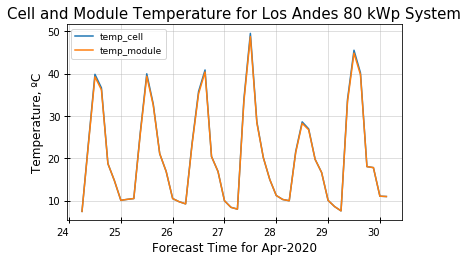

In [33]:
temperature = data_weatherforecast['temp_air'];
wind_speed = data_weatherforecast['wind_speed'];
pvtemps = pvsystem.sapm_celltemp(poa_irrad['poa_global'], wind_speed, temperature, model='roof_mount_cell_glassback');

LosAndesSys = 'Los Andes 80 kWp System';

# Cell and Module Temperature Plot

plt.style.use('fast')

pvtemps.plot();

plt.rc('font', family='Helvetica')

plt.title('Cell and Module Temperature for {}'.format(LosAndesSys), fontname="Helvetica", fontsize=15);
plt.ylabel('Temperature, ºC', fontname="Helvetica", fontsize=12);
plt.xlabel('Forecast Time for {}-{}'.format(start.strftime("%b"), start.year), fontname="Helvetica", fontsize=12);

plt.gcf().autofmt_xdate();
date_format = mpl_dates.DateFormatter('%d');
plt.gca().xaxis.set_major_formatter(date_format);

plt.tick_params(direction='inout', length=6, width=1, grid_alpha=0.5)

plt.xticks(rotation=0)
plt.grid(True);
plt.legend(fontsize=9);
plt.tight_layout;
plt.savefig('Cell_Module_Temperature.eps')

### 4.8. ANGLE OF INCIDENCE MODIFIERS

Determine the incidence angle modifier using the ASHRAE transmission model.

The ASHRAE (American Society of Heating, Refrigeration, and Air Conditioning Engineers) transmission model has been used in software such as **PVSyst**.

More info at https://pvlib-python.readthedocs.io/en/v0.7.2/generated/pvlib.iam.ashrae.html.

If the user want an approach to this concept of solar tracking (*AIM*), please check this page: http://www.solarpanelsplus.com/solar-tracking/.

Sandia has available a bunch of models that comprehends: (i.) **ASHRAE**, (ii.) **Physical**, (iii.) **Martin-Ruiz**, (iv.) **Interp** and (v.) **SAPM**.

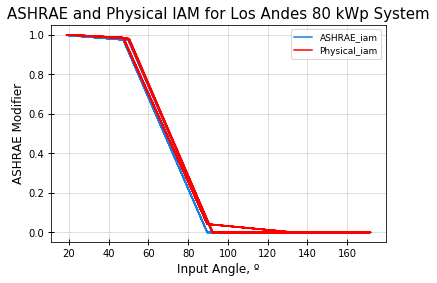

In [34]:
ashraeiam = pd.Series(pvsystem.ashraeiam(aoi, b=0.05), index=aoi);
physicaliam = pvsystem.physicaliam(aoi, n=1.526, K=4.0, L=0.002);

# ASHRAE IAM Plot

plt.style.use('fast')

ashraeiam.plot(label='ASHRAE_iam', color='#1580E4');
plt.plot(aoi, physicaliam, label='Physical_iam', color='red');

plt.rc('font', family='Helvetica')

plt.title('ASHRAE and Physical IAM for {}'.format(LosAndesSys), fontname="Helvetica", fontsize=15);
plt.ylabel('ASHRAE Modifier', fontname="Helvetica", fontsize=12);
plt.xlabel('Input Angle, º', fontname="Helvetica", fontsize=12);

plt.tick_params(direction='inout', length=6, width=1, grid_alpha=0.5)

plt.xticks(rotation=0)
plt.grid(True);
plt.legend(fontsize=9);
plt.tight_layout;
plt.savefig('ASHRAE_iam.eps')

### 4.9. EFFECTIVE IRRADIANCE
Effective irradiance is total plane of array (POA) irradiance adjusted for **angle of incidence losses**, **soiling** and **spectral mismatch**. In a general sense it can be thought of as the irradiance that is *'available'* to the PV array for power conversion. In other words, effective irradiance is the irradiance that is converted to electrical current.

More info at https://pvpmc.sandia.gov/modeling-steps/2-dc-module-iv/effective-irradiance/.

##### 4.9.1. Total Irradiance
Here it is determined the total in-plane irradiance according to its beam, sky diffuse and ground reflected components.

**RELEVANT:** It is equivalent as the Total POA section (4.6.) when the author uses the code ```irradiance.poa_components```.

More info at https://wholmgren-pvlib-python-new.readthedocs.io/en/doc-reorg2/generated/irradiance/pvlib.irradiance.total_irrad.html.

/Users/nelsonsasa07/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: pvlibDeprecationWarning: The total_irrad function was deprecated in pvlib 0.6 and will be removed in 0.7. Use get_total_irradiance instead.
  if __name__ == '__main__':


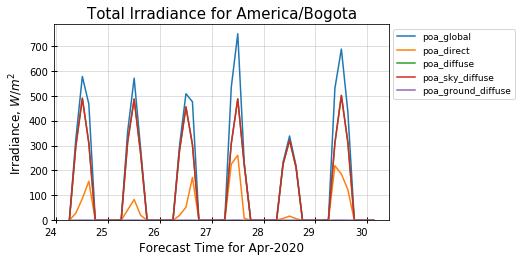

In [35]:
#Total Irradiance
total_irrad = irradiance.total_irrad(surface_tilt,
                                     surface_azimuth,
                                     solpos['apparent_zenith'],
                                     solpos['azimuth'],
                                     irrads_larson['dni'], irrads_larson['ghi'], irrads_larson['dhi'],
                                     dni_extra=dni_extra,
                                     albedo=surface_albedo,
                                     model='haydavies')

# Total Irradiance Plot

plt.style.use('fast')

total_irrad.plot(label='poa_irrad');

plt.rc('font', family='Helvetica')

plt.title('Total Irradiance for {}'.format(tz), fontname="Helvetica", fontsize=15);
plt.ylabel('Irradiance, $W/m^{2}$', fontname="Helvetica", fontsize=12);
plt.xlabel('Forecast Time for {}-{}'.format(start.strftime("%b"), start.year), fontname="Helvetica", fontsize=12);

plt.gcf().autofmt_xdate();
date_format = mpl_dates.DateFormatter('%d');
plt.gca().xaxis.set_major_formatter(date_format);

plt.tick_params(direction='inout', length=6, width=1, grid_alpha=0.5)

plt.xticks(rotation=0)
plt.ylim(0, None)
plt.grid(True);
plt.legend(loc="upper left", bbox_to_anchor=(1,1), fontsize=9);
plt.tight_layout;
plt.savefig('Total_Irradiance.eps')

**RELEVANT:** SAPM function ```pvlib.pvsystem.sapm``` generates five (5) points on a PV module’s I-V curve ($V_{oc}$, $I_{sc}$, $I_x$, $I_{xx}$, $V_{mp}$ and $I_{mp}$) according to SAND2004-3535. It assumes a reference cell temperature of 25ºC. This same function requires variables referring to spectral mismatch and reflection model modifiers that Sandia modules have **<ins>but</ins>** CEC modules don't. 

In order to solve this setback, first calculate the effective irradiance from plane of array (POA) irradiance, choosing a reflection model (```pvlib.pvsystem.physicaliam``` or ```pvlib.pvsystem.ashraeiam```), and a spectral modifier model (if the user want to account for spectrum, ```pvlib.atmosphere.first_solar_spectral_correction``` is an option that does not require SAPM parameters).

More info at: https://stackoverflow.com/questions/55916387/how-to-calculate-the-effective-irradiance-with-pvlibs-pvwatts-model.

##### 4.9.2. Precipitable Water
Calculates precipitable water (cm) from ambient air temperature (C) and relatively humidity (%) using an empirical model. The accuracy of this method is approximately 20% for moderate PW (1-3 cm) and less accurate otherwise.

**Note:** According to *weather-col.com* the relative humidity at Bogotá from April is 77%. The user can eyeball this information at https://www.weather-col.com/es/colombia/bogota-clima.

More info at https://pvlib-python.readthedocs.io/en/stable/generated/pvlib.atmosphere.gueymard94_pw.html.

In [36]:
# Precipitable Water (pw)

pw = atmosphere.gueymard94_pw(data_weatherforecast['temp_air'], relative_humidity=77)
pw.head()

2020-04-24 06:00:00-05:00    1.341359
2020-04-24 09:00:00-05:00    1.306009
2020-04-24 12:00:00-05:00    1.642915
2020-04-24 15:00:00-05:00    2.058255
2020-04-24 18:00:00-05:00    2.668168
Name: temp_air, dtype: float32

##### 4.9.3. First Solar Spectral Correction (Spectral Mismatch)
Spectral mismatch modifier is based on precipitable water and absolute (pressure corrected) airmass. Estimates a spectral mismatch modifier $M$ representing the effect on module short circuit current of variation in the spectral irradiance.

Due to the fact that this is a *'correction'* value, it can also modify the POA irradiance value by direct multiplication given a constant correction factor. This is a sensitive evaluation (as kind of interpolation). The user can try with an arbitrary value. The author will use 70%.

More info at https://pvlib-python.readthedocs.io/en/stable/generated/pvlib.atmosphere.first_solar_spectral_correction.html.

In [37]:
# Spectral Mismatch
# More information at https://pvlib-python.readthedocs.io/en/latest/generated/pvlib.atmosphere.first_solar_spectral_correction.html

spectral_mismatch_raw = atmosphere.first_solar_spectral_correction(pw, absolute_airmass, module_type='monosi', coefficients=None);

#spectral_mismatch_raw = spectral_mismatch_raw[~np.isnan(spectral_mismatch_raw)] # Removing NaN values from the array
spectral_mismatch = spectral_mismatch_raw.fillna(1); # Changing NaN values from the array to 1

spectral_mismatch.head()

2020-04-24 06:00:00-05:00    1.038514
2020-04-24 09:00:00-05:00    0.980951
2020-04-24 12:00:00-05:00    0.971318
2020-04-24 15:00:00-05:00    0.986534
2020-04-24 18:00:00-05:00    1.047924
dtype: float64

##### 4.9.4. Effective Irradiance Calculation
Here the author calculates the *effective irradiance* variable by two means: (i.) by the given theoretically equation and (ii.) by the *'correction factor'* established by the author as 70%.

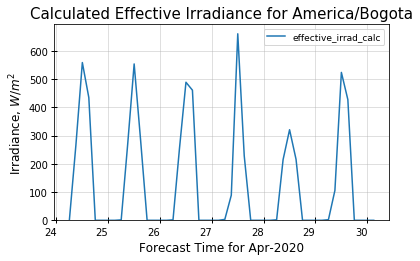

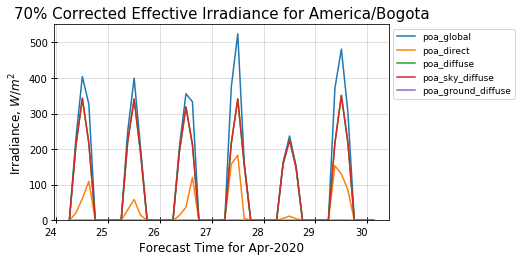

In [38]:
#physicaliam_mod = physicaliam[physicaliam != 0] # Correction tries
#physicaliam_value = np.mean(physicaliam_mod) # Correction tries

effective_irrad_calc = (total_irrad['poa_direct'] * np.cos(aoi) * physicaliam + total_irrad['poa_diffuse']) * spectral_mismatch;

effective_irrad_corr = 0.7*total_irrad;

# Calculated Effective Irradiance Plot

plt.style.use('fast')

effective_irrad_calc.plot(label='effective_irrad_calc');

plt.rc('font', family='Helvetica')

plt.title('Calculated Effective Irradiance for {}'.format(tz), fontname="Helvetica", fontsize=15);
plt.ylabel('Irradiance, $W/m^{2}$', fontname="Helvetica", fontsize=12);
plt.xlabel('Forecast Time for {}-{}'.format(start.strftime("%b"), start.year), fontname="Helvetica", fontsize=12);

plt.gcf().autofmt_xdate();
date_format = mpl_dates.DateFormatter('%d');
plt.gca().xaxis.set_major_formatter(date_format);

plt.tick_params(direction='inout', length=6, width=1, grid_alpha=0.5)

plt.xticks(rotation=0)
plt.ylim(0, None)
plt.grid(True);
plt.legend(fontsize=9);
plt.tight_layout;
plt.savefig('Effective_Irrad_Calc.eps')

# Corrected Effective Irradiance Plot

plt.style.use('fast')

effective_irrad_corr.plot(label='effective_irrad_corr');

plt.rc('font', family='Helvetica')

plt.title('70% Corrected Effective Irradiance for {}'.format(tz), fontname="Helvetica", fontsize=15);
plt.ylabel('Irradiance, $W/m^{2}$', fontname="Helvetica", fontsize=12);
plt.xlabel('Forecast Time for {}-{}'.format(start.strftime("%b"), start.year), fontname="Helvetica", fontsize=12);

plt.gcf().autofmt_xdate();
date_format = mpl_dates.DateFormatter('%d');
plt.gca().xaxis.set_major_formatter(date_format);

plt.tick_params(direction='inout', length=6, width=1, grid_alpha=0.5)

plt.xticks(rotation=0)
plt.ylim(0, None)
plt.grid(True);
plt.legend(loc="upper left", bbox_to_anchor=(1,1), fontsize=9);
plt.tight_layout;
plt.savefig('Effective_Irrad_Corr.eps')

##### 4.9.5. Effective Irradiance Troubles
If the user wants to get the effective irradiance with the ```pvsystem.sapm_effective_irradiance``` function **<ins>but</ins>** with a CEC module, the following variables are required. Therefore is a line code for the ```pvsystem.sapm``` function.

More info about this parameters at: https://pvpmc.sandia.gov/modeling-steps/dc-to-ac-conversion/sandia-inverter-model/.

```python
# Effective Irradiance

module['A4'] = -6.93e-05
module['A3'] = 0.0016606
module['A2'] = -0.0157738
module['A1'] = 0.068093
module['A0'] = 0.928385

module['B0'] = 1
module['B1'] = -0.002438
module['B2'] = 0.0003103
module['B3'] = -1.246e-05
module['B4'] = 2.11e-07
module['B5'] = -1.36e-09

module['Bvmpo'] = -0.36
module['Mbvmp'] = 0
module['Bvoco'] = -0.26
module['Mbvoc'] = 0
module['N'] = 1
module['Cells_in_Series'] = 12
module['Isco'] = 10.43
module['Aisc'] = 0
module['Impo'] = 9.83
module['C0'] = 0
module['C1'] = 0
module['C2'] = 0
module['C3'] = 0
module['Aimp'] = 0
module['Voco'] = 49.2
module['Vmpo'] = 40.2

module['FD'] = 1

effective_irradiance = pvsystem.sapm_effective_irradiance(total_irrad['poa_direct'], total_irrad['poa_diffuse'],                                                                 absolute_airmass, aoi, module)

effective_irradiance.head()

sapm_out = pvsystem.sapm(effective_irradiance, pvtemps['temp_cell'], module) #SAPM function (Section 5.2.)
```

___
## PART 5: PV POWER FORECAST

First of all, the variables at the Part 4 are recalculated here with the ```PVSystem``` and ```ModelChain``` classes (previously used the ```get_clearsky()``` method).

### 5.1. GET THE INVERSORS INFORMATION FROM MULTIPLES DATABASES

The inversors module databases are: (i.) CEC module database, (ii.) Sandia Module database, (iii.) CEC Inverter database and (iv.) Anton Driesse Inverter database.

More information at: https://pvlib-python.readthedocs.io/en/stable/generated/pvlib.pvsystem.retrieve_sam.html.

In [39]:
# Get the Inversors Characteristics from the Database Selected
# There is two modules due to the fact that the University Solar Park is compound by two different systems
# The user can check the databases here: https://github.com/BreakingBytes/simkit/tree/master/examples/PVPower/pvpower

inverters_database = 'CECInverter';

inverters = retrieve_sam(inverters_database);
inverter_A = inverters.ABB__TRIO_50_0_TL_OUTD_US_480__480V__480V__CEC_2018_; #51.24 kWp System
inverter_B = inverters.ABB__TRIO_27_6_TL_OUTD_S_US_480__480V__480V__CEC_2018_; #28.82 kWp System

___
In case that the user struggles with the search of the exact module or inverter (cannot find it at the availables Sandias' databases), try this way:

1. Search for the module or inverter at the repository by PVFree (https://pvfree.herokuapp.com/).
2. Look for the module or inverter ID that appears at PVFree (i.e. 10267) or the name of the module (i.e. LG400N2W-A5).
3. Run the code snippet below.

The user can find some examples at: https://groups.google.com/forum/m/#!topic/pvlib-python/Zc0grCqYRkA.

The author also encourages the user to the Google group forum in order to explore more about PVLIB-Python coding procedures.
___

In [40]:
import requests
get_module = requests.get('https://pvfree.herokuapp.com/api/v1/cecmodule/10267')
get_module.json()

{'A_c': 2.0,
 'Adjust': 9.380614,
 'BIPV': False,
 'Bifacial': False,
 'Date': '2018-11-04',
 'I_L_ref': 10.48115,
 'I_mp_ref': 9.86,
 'I_o_ref': 1.807477e-11,
 'I_sc_ref': 10.47,
 'Length': 2.0,
 'N_s': 72,
 'Name': 'LG Electronics Inc. LG400N2W-A5',
 'PTC': 368.4,
 'R_s': 0.312859,
 'R_sh_ref': 293.80542,
 'STC': 400.316,
 'T_NOCT': 47.7,
 'Technology': 'Mono-c-Si',
 'V_mp_ref': 40.6,
 'V_oc_ref': 49.3,
 'Version': 'SAM 2018.10.29',
 'Width': 1.0,
 'a_ref': 1.821208,
 'alpha_sc': 0.003141,
 'beta_oc': -0.12818,
 'created_on': '2019-02-12',
 'gamma_r': -0.36,
 'id': 10267,
 'modified_on': '2019-02-12',
 'resource_uri': '/api/v1/cecmodule/10267/'}

In [41]:
# Due to the fact that the exact module was not found in those databases, the author proceed to create it
# LG Electronics Inc. LG400N2W-A5

# Name,Technology,Bifacial,STC,PTC,A_c,Length,Width,N_s,I_sc_ref,V_oc_ref,I_mp_ref,V_mp_ref,alpha_sc,beta_oc,T_NOCT,a_ref,I_L_ref,I_o_ref,R_s,R_sh_ref,Adjust,gamma_r,BIPV,Version,Date
# LG Electronics Inc. LG400N2W-A5,Mono-c-Si,0,400.316000,368.400000,2,2,1,72,10.470000,49.300000,9.860000,40.600000,0.003141,-0.128180,47.700000,1.821208,10.481150,1.807477e-11,0.312859,293.805420,9.380614,-0.360000,N,SAM 2018.11.11 r2,1/3/2019

LG400N2WA5 = {
'BIPV':                'N',
'Date':          '1/3/2019',
'T_NOCT':             47.7,
'A_c':                 2.0,
'N_s':                  72,
'I_sc_ref':          10.47,
'V_oc_ref':           49.3,
'I_mp_ref':           9.86,
'V_mp_ref':           40.6,
'alpha_sc':       0.003141,
'beta_oc':        -0.12180,
'a_ref':            1.821208,
'I_L_ref':          10.481150,
'I_o_ref':         1.807477e-11,
'R_s':               0.312859,
'R_sh_ref':         293.805420,
'Adjust':            9.380614,
'gamma_r':          -0.36,
'Version':          'NRELv1',
'PTC':               368.4,
'Technology':    'Mono-c-Si',
'Name': 'LG Electronics LG385N2W-A5'}

module = pd.Series(LG400N2WA5, name='LG_Electronics_LG385N2W_A5')

In [42]:
# Definition of the Los Andes Solar Systems

#System A
sysA_name = 'Los Andes 51.25 kWp System Capacity';
system_A = PVSystem(module_parameters=module, inverter_parameters=inverter_A, surface_azimuth=180, 
                    surface_tilt=10, modules_per_string=16, strings_per_inverter=8)

#System B
sysB_name = 'Los Andes 28.82 kWp System Capacity';
system_B = PVSystem(module_parameters=module, inverter_parameters=inverter_B, surface_azimuth=180, 
                    surface_tilt=10, modules_per_string=18, strings_per_inverter=4)

### 5.2. SYSTEM'S FIVE PARAMETERS BY SINGLE DIODE METHOD INITIALIZATION

Here is solved the single-diode model to obtain a photovoltaic I-V curve.

More info about de Single-Diode Method at https://pvlib-python.readthedocs.io/en/latest/generated/pvlib.pvsystem.singlediode.html#pvlib.pvsystem.singlediode.

Due to the fact that the SAPM funcion ```pvsystem.sapm``` requires many parameters that Sandia' modules provides but CEC modules doesn't, it is needed to use another function. 

More info about the function at https://pvlib-python.readthedocs.io/en/stable/generated/pvlib.pvsystem.sapm.html. Also, more info about the module at https://www.lg.com/us/business/solar-panels/lg-LG400N2W-A5.

#### 5.2.1. Method 1
The ***Method 1*** refers to, first, get the maximum *n* values of the parameters **<ins>effective irradiance</ins>** and **<ins>cell temperature</ins>** (*n* values according to the number of days that are analyzed) and then using the function ```pvsystem.singlediode``` to obtain values of $I_{mp}$, $V_{mp}$ and $P_{mp}$.

**Note:** This method retrieved an $I_{mp}$, $V_{mp}$ and $P_{mp}$ value per day analyzed, not a *'continuous'* array during all days.

##### 5.2.1.1. De Soto et. al. Model
In order to achieve the same goal, it will be used the function ```pvsystem.calcparams_desoto``` to obtain five parameter values for the single diode equation at effective irradiance and cell temperature using the De Soto et al. model and then be used by single diode to calculate an IV curve.

More info at https://pvlib-python.readthedocs.io/en/stable/generated/pvlib.pvsystem.calcparams_desoto.html.

In [44]:
max_eff_irrad = effective_irrad_calc.resample('1d').max();

max_location = effective_irrad_calc.resample('1d').apply(lambda s: s.idxmax());

max_temp_cell = pvtemps['temp_cell'].resample('1d').max();

cases = list(zip(max_location.values, max_eff_irrad.values, max_temp_cell.values));
conditions = pd.DataFrame(cases, columns=['Datetime', 'Geff', 'Tcell']);
conditions = conditions.round(2);
conditions.head()

,Datetime,Geff,Tcell
0,2020-04-24 17:00:00,558.76,39.81
1,2020-04-25 17:00:00,553.85,39.93
2,2020-04-26 17:00:00,488.97,40.83
3,2020-04-27 17:00:00,660.64,49.47
4,2020-04-28 17:00:00,320.79,28.59


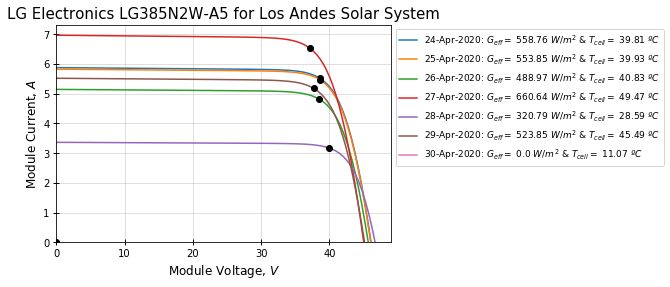

   i_sc   v_oc  i_mp   v_mp    p_mp   i_x  i_xx
0  5.88  46.11  5.52  38.62  213.22  5.84  4.18
1  5.83  46.07  5.47  38.59  211.24  5.78  4.15
2  5.15  45.70  4.83  38.42  185.67  5.11  3.69
3  6.97  45.04  6.52  37.20  242.69  6.92  4.85
4  3.36  46.70  3.17  40.00  126.86  3.34  2.50
5  5.52  45.16  5.18  37.74  195.40  5.48  3.93
6  0.00   0.00  0.00   0.00    0.00  0.00  0.00


<Figure size 432x288 with 0 Axes>

In [45]:
IL_DS, I0_DS, Rs_DS, Rsh_DS, nNsVth_DS = pvsystem.calcparams_desoto(conditions['Geff'],
                                                     conditions['Tcell'],
                                                     module['alpha_sc'],
                                                     module['a_ref'],
                                                     module['I_L_ref'],
                                                     module['I_o_ref'],
                                                     module['R_sh_ref'],
                                                     module['R_s'],
                                                     EgRef=1.121, #Retrieved from last link at above description
                                                     dEgdT=-0.0002677) #Retrieved from last link at above description

curve_info_DS = pvsystem.singlediode(photocurrent=IL_DS,
                                  saturation_current=I0_DS,
                                  resistance_series=Rs_DS,
                                  resistance_shunt=Rsh_DS,
                                  nNsVth=nNsVth_DS,
                                  ivcurve_pnts=100,
                                  method='lambertw')

# I-V Curves Plot
plt.style.use('fast')
plt.rc('font', family='Helvetica')
plt.figure()
                                                     
for i, case in conditions.iterrows():
    label = (
        f"{case['Datetime'].strftime('%d-%b-%Y')}: "
        "$G_{eff} = $ " + f"{case['Geff']} $W/m^2$ & "
        "$T_{cell} = $ " + f"{case['Tcell']} $ºC$")
    
    plt.plot(curve_info_DS['v'][i], curve_info_DS['i'][i], label=label)
    v_mp = curve_info_DS['v_mp'][i]
    i_mp = curve_info_DS['i_mp'][i]
    # mark the MPP
    plt.plot([v_mp], [i_mp], ls='', marker='o', c='k')

plt.tick_params(direction='inout', length=6, width=1, grid_alpha=0.5)
                                                     
plt.title(LG400N2WA5['Name'] + ' for Los Andes Solar System', fontname="Helvetica", fontsize=15);
plt.ylabel('Module Current, $A$', fontname="Helvetica", fontsize=12);
plt.xlabel('Module Voltage, $V$', fontname="Helvetica", fontsize=12);
plt.grid(True);
plt.ylim(0, None)
plt.xlim(0, None)
plt.legend(loc="upper left", bbox_to_anchor=(1,1), fontsize=9);
plt.tight_layout;
plt.savefig('DS_IV_Curves.eps') 
plt.show()
plt.gcf().set_tight_layout(True)

data_summary_DS = pd.DataFrame({'i_sc': curve_info_DS['i_sc'],
                                'v_oc': curve_info_DS['v_oc'],
                                'i_mp': curve_info_DS['i_mp'],
                                'v_mp': curve_info_DS['v_mp'],
                                'p_mp': curve_info_DS['p_mp'],
                                'i_x': curve_info_DS['i_x'],
                                'i_xx': curve_info_DS['i_xx']})

data_summary_DS = data_summary_DS.round(2)
print(data_summary_DS)

##### 5.2.1.2. CEC Model
The function calculates five parameter values for the single diode equation at effective irradiance and cell temperature using the CEC model. The CEC model differs from the De Soto et al. model by the parameter *Adjust* (the adjustment to the temperature coefficient for short circuit current, in percent).

**Note:** The *Adjust* is given by the manufacturer of the module, i.e. LG Electronics (https://www.lg.com/us/business/solar-panels/lg-LG400N2W-A5).

More info at https://pvlib-python.readthedocs.io/en/latest/generated/pvlib.pvsystem.calcparams_cec.html#pvlib.pvsystem.calcparams_cec.

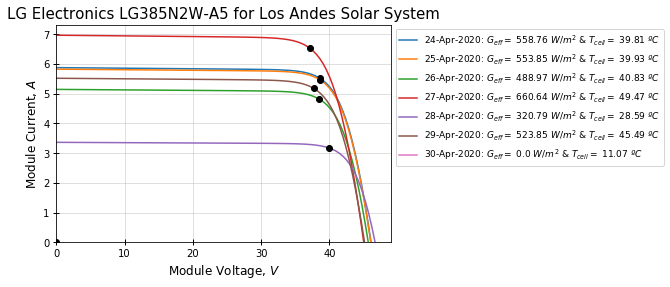

   i_sc   v_oc  i_mp   v_mp    p_mp   i_x  i_xx
0  5.88  46.11  5.52  38.62  213.22  5.84  4.18
1  5.83  46.07  5.47  38.59  211.24  5.78  4.15
2  5.15  45.70  4.83  38.42  185.67  5.11  3.69
3  6.97  45.04  6.52  37.20  242.69  6.92  4.85
4  3.36  46.70  3.17  40.00  126.86  3.34  2.50
5  5.52  45.16  5.18  37.74  195.40  5.48  3.93
6  0.00   0.00  0.00   0.00    0.00  0.00  0.00


<Figure size 432x288 with 0 Axes>

In [46]:
IL_CEC, I0_CEC, Rs_CEC, Rsh_CEC, nNsVth_CEC = pvsystem.calcparams_cec(conditions['Geff'],
                                                     conditions['Tcell'],
                                                     module['alpha_sc'],
                                                     module['a_ref'],
                                                     module['I_L_ref'],
                                                     module['I_o_ref'],
                                                     module['R_sh_ref'],
                                                     module['R_s'],
                                                     Adjust=0.02,
                                                     EgRef=1.121, #Retrieved from last link at above description
                                                     dEgdT=-0.0002677) #Retrieved from last link at above description

curve_info_CEC = pvsystem.singlediode(photocurrent=IL_CEC,
                                  saturation_current=I0_CEC,
                                  resistance_series=Rs_CEC,
                                  resistance_shunt=Rsh_CEC,
                                  nNsVth=nNsVth_CEC,
                                  ivcurve_pnts=100,
                                  method='lambertw')

# I-V Curves Plot
plt.style.use('fast')
plt.rc('font', family='Helvetica')
plt.figure()
                                                     
for i, case in conditions.iterrows():
    label = (
        f"{case['Datetime'].strftime('%d-%b-%Y')}: "
        "$G_{eff} = $ " + f"{case['Geff']} $W/m^2$ & "
        "$T_{cell} = $ " + f"{case['Tcell']} $ºC$")
    
    plt.plot(curve_info_CEC['v'][i], curve_info_CEC['i'][i], label=label)
    v_mp = curve_info_CEC['v_mp'][i]
    i_mp = curve_info_CEC['i_mp'][i]
    # mark the MPP
    plt.plot([v_mp], [i_mp], ls='', marker='o', c='k')

plt.tick_params(direction='inout', length=6, width=1, grid_alpha=0.5)
                                                     
plt.title(LG400N2WA5['Name'] + ' for Los Andes Solar System', fontname="Helvetica", fontsize=15);
plt.ylabel('Module Current, $A$', fontname="Helvetica", fontsize=12);
plt.xlabel('Module Voltage, $V$', fontname="Helvetica", fontsize=12);
plt.ylim(0, None)
plt.xlim(0, None)
plt.grid(True);
plt.legend(loc="upper left", bbox_to_anchor=(1,1), fontsize=9);
plt.tight_layout;
plt.savefig('CEC_IV_Curves.eps') 
plt.show()
plt.gcf().set_tight_layout(True)

data_summary_CEC = pd.DataFrame({'i_sc': curve_info_CEC['i_sc'],
                                'v_oc': curve_info_CEC['v_oc'],
                                'i_mp': curve_info_CEC['i_mp'],
                                'v_mp': curve_info_CEC['v_mp'],
                                'p_mp': curve_info_CEC['p_mp'],
                                'i_x': curve_info_CEC['i_x'],
                                'i_xx': curve_info_CEC['i_xx']})

data_summary_CEC = data_summary_CEC.round(2)
print(data_summary_CEC)

___
**Note:** The ```pvsystem.singlediode``` function gets the $I_{mp}$, $V_{mp}$ and $P_{mp}$ values but also the user could get those by applying the function ```pvsystem.max_power_point```. An example of the code is snipped below.

More info at https://pvlib-python.readthedocs.io/en/latest/generated/pvlib.pvsystem.max_power_point.html#pvlib.pvsystem.max_power_point.
___

In [47]:
mpp_DS = pvsystem.max_power_point(photocurrent=IL_DS,
                                  saturation_current=I0_DS,
                                  resistance_series=Rs_DS,
                                  resistance_shunt=Rsh_DS,
                                  nNsVth=nNsVth_DS, 
                                  method='brentq') #For the Single-Diode Method by De Soto et. al. Parameters

mpp_CEC = pvsystem.max_power_point(photocurrent=IL_CEC,
                                  saturation_current=I0_CEC,
                                  resistance_series=Rs_CEC,
                                  resistance_shunt=Rsh_CEC,
                                  nNsVth=nNsVth_CEC, 
                                  method='brentq')

mpp_CEC.head() #For the Single-Diode Method by CEC Parameters

,i_mp,v_mp,p_mp
0,5.523053,38.604701,213.215820
1,5.474642,38.584381,211.235689
2,4.834688,38.403350,185.668207
3,6.525405,37.192052,242.693211
4,3.173128,39.979307,126.859476


##### 5.2.1.3. Scalating Single Diode Results for the Los Andes Photovoltaic System
The results obtained from the ```pvsystem.singlediode``` method are equivalent to the production of a single module of the photovoltaic system. In order to get the complete production, the method ```pvsystem.scale_voltage_current_power``` is used. This method scales the voltage, current, and power of the designen system (Section 5.1. — Definition of the Los Andes Solar Systems).

More info at https://cwhanse-pvlib-python.readthedocs.io/en/latest/generated/pvlib.pvsystem.scale_voltage_current_power.html.

In [48]:
# Scalating De Soto et. al. Single Diode Results
results_DS = pd.DataFrame(data_summary_DS, columns=data_summary_DS.keys())

scaled_results_DS_SysA = system_A.scale_voltage_current_power(results_DS)
scaled_results_DS_SysB = system_B.scale_voltage_current_power(results_DS)

scaled_results_DS_SysA.head()

,i_sc,v_oc,i_mp,v_mp,p_mp,i_x,i_xx
0,47.04,737.76,44.16,617.92,27292.16,46.72,33.44
1,46.64,737.12,43.76,617.44,27038.72,46.24,33.20
2,41.20,731.20,38.64,614.72,23765.76,40.88,29.52
3,55.76,720.64,52.16,595.20,31064.32,55.36,38.80
4,26.88,747.20,25.36,640.00,16238.08,26.72,20.00


In [49]:
# Scalating CEC Single Diode Results
results_CEC = pd.DataFrame(data_summary_CEC, columns=data_summary_CEC.keys())

scaled_results_CEC_SysA = system_A.scale_voltage_current_power(results_CEC)
scaled_results_CEC_SysB = system_B.scale_voltage_current_power(results_CEC)

scaled_results_CEC_SysA.head()

,i_sc,v_oc,i_mp,v_mp,p_mp,i_x,i_xx
0,47.04,737.76,44.16,617.92,27292.16,46.72,33.44
1,46.64,737.12,43.76,617.44,27038.72,46.24,33.20
2,41.20,731.20,38.64,614.72,23765.76,40.88,29.52
3,55.76,720.64,52.16,595.20,31064.32,55.36,38.80
4,26.88,747.20,25.36,640.00,16238.08,26.72,20.00


#### 5.2.2. Method 2
The ***Method 2*** is kinda the opposite of the *Method 1*. 

This ***Method 2*** refers to, first, to use the function ```pvsystem.singlediode``` to obtain values of $I_{mp}$, $V_{mp}$ and $P_{mp}$ and then getting the maximum *n* values of the parameters **<ins>effective irradiance</ins>** and **<ins>cell temperature</ins>** (*n* values according to the number of days that are analyzed) .

This method retrieved an $I_{mp}$, $V_{mp}$ and $P_{mp}$ value continuous array (or list, series, DataFrame) per day analyzed, not an *'unique'* value per all days.

**Note:** The ***Method 2*** uses the De Soto et. al. model to then run the ```pvsystem.singlediode``` function.

In [50]:
IL, I0, Rs, Rsh, nNsVth = pvsystem.calcparams_desoto(effective_irrad_calc,
                                                     pvtemps['temp_cell'],
                                                     module['alpha_sc'],
                                                     module['a_ref'],
                                                     module['I_L_ref'],
                                                     module['I_o_ref'],
                                                     module['R_sh_ref'],
                                                     module['R_s'],
                                                     EgRef=1.121, #Retrieved from last link at above description
                                                     dEgdT=-0.0002677) #Retrieved from last link at above description

curve_info = pvsystem.singlediode(photocurrent=IL,
                                  saturation_current=I0,
                                  resistance_series=Rs,
                                  resistance_shunt=Rsh,
                                  nNsVth=nNsVth,
                                  ivcurve_pnts=100,
                                  method='lambertw')

# Scalating De Soto et. al. Single Diode Results
data_i_sc = pd.Series(curve_info['i_sc'])
data_v_oc = pd.Series(curve_info['v_oc'])
data_i_mp = pd.Series(curve_info['i_mp'])
data_v_mp = pd.Series(curve_info['v_mp'])
data_p_mp = pd.Series(curve_info['p_mp'])
data_i_x = pd.Series(curve_info['i_x'])
data_i_xx = pd.Series(curve_info['i_xx'])

results_general = pd.DataFrame({'i_sc': data_i_sc, 
                        'v_oc': data_v_oc,
                        'i_mp': data_i_mp, 
                        'v_mp': data_v_mp, 
                        'p_mp': data_p_mp, 
                        'i_x': data_i_x,
                        'i_xx': data_i_xx})

sc_SysA = system_A.scale_voltage_current_power(results_general)
sc_SysA['Datetime'] = pd.to_datetime(effective_irrad_calc.index)
sc_SysA = sc_SysA.set_index('Datetime')

sc_SysB = system_B.scale_voltage_current_power(results_general)
sc_SysB['Datetime'] = pd.to_datetime(effective_irrad_calc.index)
sc_SysB = sc_SysB.set_index('Datetime')

In [51]:
# Max Values of Scalated Data for SysA

max_isc_SysA = sc_SysA['i_sc'].resample('1d').max();
max_voc_SysA = sc_SysA['v_oc'].resample('1d').max();
max_imp_SysA = sc_SysA['i_mp'].resample('1d').max();
max_vmp_SysA = sc_SysA['v_mp'].resample('1d').max();
max_pmp_SysA = sc_SysA['p_mp'].resample('1d').max();
max_ix_SysA = sc_SysA['i_x'].resample('1d').max();
max_ixx_SysA = sc_SysA['i_xx'].resample('1d').max();

cases_sc_SysA = list(zip(max_isc_SysA.values, max_voc_SysA.values, max_imp_SysA.values, max_vmp_SysA.values, 
                         max_pmp_SysA.values, max_ix_SysA.values, max_ixx_SysA.values));

sc_max_SysA = pd.DataFrame(cases_sc_SysA, columns=['i_sc', 'v_oc', 'i_mp', 'v_mp', 'p_mp', 'i_x', 'i_xx']);
sc_max_SysA = sc_max_SysA.round(2);
sc_max_SysA.head()

# Max Values of Scalated Data for SysB

max_isc_SysB = sc_SysB['i_sc'].resample('1d').max();
max_voc_SysB = sc_SysB['v_oc'].resample('1d').max();
max_imp_SysB = sc_SysB['i_mp'].resample('1d').max();
max_vmp_SysB = sc_SysB['v_mp'].resample('1d').max();
max_pmp_SysB = sc_SysB['p_mp'].resample('1d').max();
max_ix_SysB = sc_SysB['i_x'].resample('1d').max();
max_ixx_SysB = sc_SysB['i_xx'].resample('1d').max();

cases_sc_SysB = list(zip(max_isc_SysB.values, max_voc_SysB.values, max_imp_SysB.values, max_vmp_SysB.values, 
                         max_pmp_SysB.values, max_ix_SysB.values, max_ixx_SysB.values));

sc_max_SysB = pd.DataFrame(cases_sc_SysB, columns=['i_sc', 'v_oc', 'i_mp', 'v_mp', 'p_mp', 'i_x', 'i_xx']);
sc_max_SysB = sc_max_SysB.round(2);
sc_max_SysB.head()

,i_sc,v_oc,i_mp,v_mp,p_mp,i_x,i_xx
0,23.52,847.24,22.09,730.16,15351.77,23.34,16.72
1,23.31,841.46,21.90,723.61,15209.00,23.14,16.59
2,20.56,846.34,19.33,729.65,13634.45,20.40,14.81
3,27.88,829.30,26.10,713.58,17474.23,27.68,19.40
4,13.46,846.19,12.69,732.09,9133.96,13.36,9.99


___
## PART 6: PV SYSTEM OUTPUTS

System outputs (DC voltage, DC current, DC power, AC power, module temperature and daily energy)*manually calculated* by the code sequence developed in this *Jupyter Notebook*. 

It is highlighted as manually calculated since later it will be compared with the *ModelChain* class.

___
**Note:** First, the code snipped below helps to create the bar plots by creating parameters as bars' width and integers of the days for the *x-label*.
___

### 6.1. DC VOLTAGE

In [53]:
bar_width = 0.2;
x = np.arange(len(conditions['Datetime']))

days = np.linspace(int(start.day), int(end.day), len(conditions['Datetime']))

int_days = []
for day in days:
    int_days.append(int(day))

int_days

[24, 25, 26, 27, 28, 29, 30]

,Day,SysA_Method_1,SysB_Method_1,SysA_Method_2,SysB_Method_2
0,24,617.9,695.2,649.0,730.2
1,25,617.4,694.6,643.2,723.6
2,26,614.7,691.6,648.6,729.6
3,27,595.2,669.6,634.3,713.6
4,28,640.0,720.0,650.7,732.1
5,29,603.8,679.3,615.1,692.0
6,30,0.0,0.0,0.0,0.0


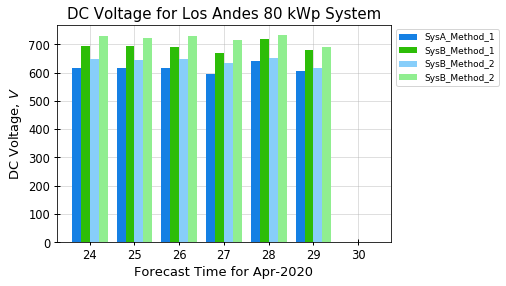

In [99]:
r1 = np.arange(len(conditions['Datetime']))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]
r4 = [x + bar_width for x in r3]

# DC Voltage Plot

plt.style.use('fast')

plt.bar(r1, scaled_results_DS_SysA['v_mp'], bar_width, label='SysA_Method_1', color='#1580E4');
plt.bar(r2, scaled_results_DS_SysB['v_mp'], bar_width, label='SysB_Method_1', color='#2DBD07');

plt.bar(r3, sc_max_SysA['v_mp'], bar_width, label='SysB_Method_2', color='lightskyblue');
plt.bar(r4, sc_max_SysB['v_mp'], bar_width, label='SysB_Method_2', color='lightgreen');

plt.rc('font', family='Helvetica')

plt.title('DC Voltage for {}'.format(LosAndesSys), fontname="Helvetica", fontsize=15);
plt.ylabel('DC Voltage, $V$', fontname="Helvetica", fontsize=13);
plt.xlabel('Forecast Time for {}-{}'.format(start.strftime("%b"), start.year), fontname="Helvetica", fontsize=13);

plt.tick_params(direction='inout', length=6, width=1, grid_alpha=0.5, labelsize=11.5)

plt.rcParams['axes.axisbelow'] = True;
plt.xticks(x + bar_width + bar_width/2, int_days)
plt.ylim(0, None)
plt.grid(True);
plt.legend(loc="upper left", bbox_to_anchor=(1,1), fontsize=9);
plt.tight_layout;
plt.savefig('DC_Voltage_Manual.eps')

# Description of the Results
sgr_DC_voltage = list(zip(int_days, scaled_results_DS_SysA['v_mp'], scaled_results_DS_SysB['v_mp'],
                          sc_max_SysA['v_mp'], sc_max_SysB['v_mp']));
sgr_DC_voltage = pd.DataFrame(sgr_DC_voltage, columns=['Day', 'SysA_Method_1', 'SysB_Method_1',
                                                       'SysA_Method_2', 'SysB_Method_2']);
sgr_DC_voltage = sgr_DC_voltage.round(1);
sgr_DC_voltage

### 6.2. DC CURRENT

,Day,SysA_Method_1,SysB_Method_1,SysA_Method_2,SysB_Method_2
0,24,44.2,22.1,44.2,22.1
1,25,43.8,21.9,43.8,21.9
2,26,38.6,19.3,38.7,19.3
3,27,52.2,26.1,52.2,26.1
4,28,25.4,12.7,25.4,12.7
5,29,41.4,20.7,41.4,20.7
6,30,0.0,0.0,0.0,0.0


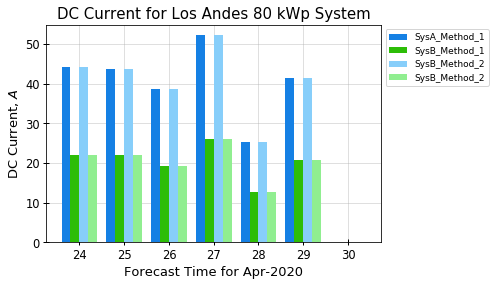

In [55]:
# DC Voltage Plot

plt.style.use('fast')

plt.bar(r1, scaled_results_DS_SysA['i_mp'], bar_width, label='SysA_Method_1', color='#1580E4');
plt.bar(r2, scaled_results_DS_SysB['i_mp'], bar_width, label='SysB_Method_1', color='#2DBD07');

plt.bar(r3, sc_max_SysA['i_mp'], bar_width, label='SysB_Method_2', color='lightskyblue');
plt.bar(r4, sc_max_SysB['i_mp'], bar_width, label='SysB_Method_2', color='lightgreen');

plt.rc('font', family='Helvetica')
plt.rcParams['axes.axisbelow'] = True;

plt.title('DC Current for {}'.format(LosAndesSys), fontname="Helvetica", fontsize=15);
plt.ylabel('DC Current, $A$', fontname="Helvetica", fontsize=13);
plt.xlabel('Forecast Time for {}-{}'.format(start.strftime("%b"), start.year), fontname="Helvetica", fontsize=13);

plt.tick_params(direction='inout', length=6, width=1, grid_alpha=0.5, labelsize=11.5)

plt.xticks(x + bar_width + bar_width/2, int_days)
plt.ylim(0, None)
plt.grid(True);
plt.legend(loc="upper left", bbox_to_anchor=(1,1), fontsize=9);
plt.tight_layout;
plt.savefig('DC_Current_Manual.eps')

# Description of the Results
sgr_DC_current = list(zip(int_days, scaled_results_DS_SysA['i_mp'], scaled_results_DS_SysB['i_mp'],
                          sc_max_SysA['i_mp'], sc_max_SysB['i_mp']));
sgr_DC_current = pd.DataFrame(sgr_DC_current, columns=['Day', 'SysA_Method_1', 'SysB_Method_1',
                                                       'SysA_Method_2', 'SysB_Method_2']);
sgr_DC_current = sgr_DC_current.round(1);
sgr_DC_current

### 6.3. DC POWER

,Day,SysA_Method_1,SysB_Method_1,Total_Method_1,SysA_Method_2,SysB_Method_2,Total_Method_2
0,24,27.3,15.4,42.6,27.3,15.4,42.6
1,25,27.0,15.2,42.2,27.0,15.2,42.2
2,26,23.8,13.4,37.1,24.2,13.6,37.9
3,27,31.1,17.5,48.5,31.1,17.5,48.5
4,28,16.2,9.1,25.4,16.2,9.1,25.4
5,29,25.0,14.1,39.1,25.0,14.1,39.1
6,30,0.0,0.0,0.0,0.0,0.0,0.0


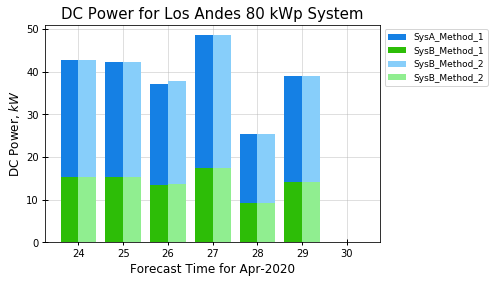

In [117]:
kilo = 1e3;
width = 0.4; #With for Stacked Bar Plots

# DC Power Plot

plt.style.use('fast')

plt.bar(r1, scaled_results_DS_SysA['p_mp']/kilo, width, label='SysA_Method_1', color='#1580E4', bottom=scaled_results_DS_SysB['p_mp']/kilo);
plt.bar(r1, scaled_results_DS_SysB['p_mp']/kilo, width, label='SysB_Method_1', color='#2DBD07');

plt.bar(r3, sc_max_SysA['p_mp']/kilo, width, label='SysB_Method_2', color='lightskyblue', bottom=sc_max_SysB['p_mp']/kilo);
plt.bar(r3, sc_max_SysB['p_mp']/kilo, width, label='SysB_Method_2', color='lightgreen');

plt.rc('font', family='Helvetica')
plt.rcParams['axes.axisbelow'] = True;

plt.title('DC Power for {}'.format(LosAndesSys), fontname="Helvetica", fontsize=15);
plt.ylabel('DC Power, $kW$', fontname="Helvetica", fontsize=12);
plt.xlabel('Forecast Time for {}-{}'.format(start.strftime("%b"), start.year), fontname="Helvetica", fontsize=12);

plt.tick_params(direction='inout', length=6, width=1, grid_alpha=0.5)

plt.xticks(x + width/2, int_days)
plt.ylim(0, None)
plt.grid(True);
plt.legend(loc="upper left", bbox_to_anchor=(1,1), fontsize=9);
plt.tight_layout;
plt.savefig('DC_Power_Manual.eps')

# Description of the Results
DC_power_sum_method_1 = scaled_results_DS_SysA['p_mp']/kilo + scaled_results_DS_SysB['p_mp']/kilo
DC_power_sum_method_2 = sc_max_SysA['p_mp']/kilo + sc_max_SysB['p_mp']/kilo

scaled_global_DC_results = list(zip(int_days, scaled_results_DS_SysA['p_mp']/kilo, scaled_results_DS_SysB['p_mp']/kilo, 
                                    DC_power_sum_method_1, sc_max_SysA['p_mp']/kilo, sc_max_SysB['p_mp']/kilo, 
                                    DC_power_sum_method_2));
scaled_global_DC_results = pd.DataFrame(scaled_global_DC_results, columns=['Day', 'SysA_Method_1', 'SysB_Method_1',
                                                                           'Total_Method_1', 'SysA_Method_2',
                                                                           'SysB_Method_2', 'Total_Method_2']);
scaled_global_DC_results = scaled_global_DC_results.round(1);
scaled_global_DC_results

### 6.4. AC POWER
Here is applied the ```pvsystem.snlinverter``` method in order to converts DC power and voltage to AC power using Sandia’s Grid-Connected PV Inverter model.

The ```pvsystem.snlinverter``` method determines the AC power output of an inverter given the DC voltage, DC power, and appropriate Sandia Grid-Connected Photovoltaic Inverter Model parameters. The output, ac_power, is clipped at the maximum power output, and gives a negative power during low-input power conditions, but does NOT account for maximum power point tracking voltage windows nor maximum current or voltage limits on the inverter.

More info at: https://pvlib-python.readthedocs.io/en/stable/generated/pvlib.pvsystem.snlinverter.html.

___
**Note:** To get the information of a function, add at the end of the line code ```??```, i.e.:
```python
pvlib.pvsystem.snlinverter??
```
___

,Day,SysA_Method_1,SysB_Method_1,Total_Method_1,SysA_Method_2,SysB_Method_2,Total_Method_2
0,24,26.8,15.0,41.8,26.8,15.0,41.8
1,25,26.5,14.9,41.4,26.5,14.9,41.4
2,26,23.3,13.1,36.4,23.8,13.4,37.1
3,27,30.5,17.1,47.6,30.5,17.1,47.6
4,28,15.9,8.9,24.8,15.9,8.9,24.8


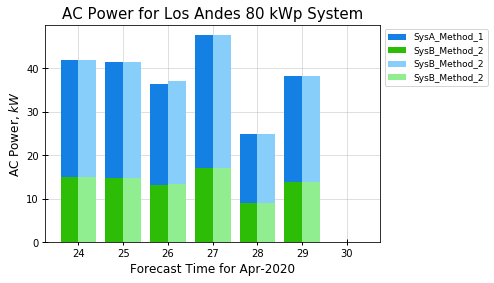

In [118]:
Pot_AC_SysA_method_1 = pvlib.pvsystem.snlinverter(scaled_results_DS_SysA['v_mp'], scaled_results_DS_SysA['p_mp'], 
                                         inverter_A)/kilo;
Pot_AC_SysB_method_1 = pvlib.pvsystem.snlinverter(scaled_results_DS_SysB['v_mp'], scaled_results_DS_SysB['p_mp'], 
                                                  inverter_B)/kilo;

Pot_AC_SysA_method_2 = pvlib.pvsystem.snlinverter(sc_max_SysA['v_mp'], sc_max_SysA['p_mp'], inverter_A)/kilo;
Pot_AC_SysB_method_2 = pvlib.pvsystem.snlinverter(sc_max_SysB['v_mp'], sc_max_SysB['p_mp'], inverter_B)/kilo;

# AC Power Plot

plt.style.use('fast')

plt.bar(r1, Pot_AC_SysA_method_1, width, label='SysA_Method_1', color='#1580E4', bottom=Pot_AC_SysB_method_1);
plt.bar(r1, Pot_AC_SysB_method_1, width, label='SysB_Method_2', color='#2DBD07');

plt.bar(r3, Pot_AC_SysA_method_2, width, label='SysB_Method_2', color='lightskyblue', bottom=Pot_AC_SysB_method_2);
plt.bar(r3, Pot_AC_SysB_method_2, width, label='SysB_Method_2', color='lightgreen');

plt.rc('font', family='Helvetica')
plt.rcParams['axes.axisbelow'] = True;

plt.title('AC Power for {}'.format(LosAndesSys), fontname="Helvetica", fontsize=15);
plt.ylabel('AC Power, $kW$', fontname="Helvetica", fontsize=12);
plt.xlabel('Forecast Time for {}-{}'.format(start.strftime("%b"), start.year), fontname="Helvetica", fontsize=12);

plt.tick_params(direction='inout', length=6, width=1, grid_alpha=0.5)

plt.xticks(x + width/2, int_days)
plt.ylim(0, None)
plt.grid(True);
plt.legend(loc="upper left", bbox_to_anchor=(1,1), fontsize=9);
plt.tight_layout;
plt.savefig('AC_Power_Manual.eps')

# Description of the Results
AC_power_sum_method_1 = Pot_AC_SysA_method_1 + Pot_AC_SysB_method_1
AC_power_sum_method_2 = Pot_AC_SysA_method_2 + Pot_AC_SysB_method_2

scaled_global_AC_results = list(zip(int_days, Pot_AC_SysA_method_1, Pot_AC_SysB_method_1, AC_power_sum_method_1,
                                    Pot_AC_SysA_method_2, Pot_AC_SysB_method_2, AC_power_sum_method_2));
scaled_global_AC_results = pd.DataFrame(scaled_global_AC_results, columns=['Day', 'SysA_Method_1', 'SysB_Method_1',
                                                                           'Total_Method_1', 'SysA_Method_2',
                                                                           'SysB_Method_2', 'Total_Method_2']);
scaled_global_AC_results = scaled_global_AC_results.round(1);
scaled_global_AC_results.head()

### 6.5. DC vs. AC POWER COMPARISON

,Stat,Sys_A,Sys_B
0,Slope,0.9824,0.9800
1,Intercept,-0.0349,-0.0258
2,r_value,1.0000,1.0000
3,Std. Error,0.0006,0.0009


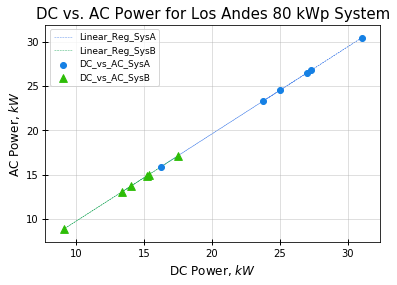

In [110]:
# Deleting (0,0) Values (Last Row of DataFrame)
x_SysA = scaled_results_DS_SysA[:-1]/kilo
y_SysA = Pot_AC_SysA_method_1[:-1]

x_SysB = scaled_results_DS_SysB[:-1]/kilo
y_SysB = Pot_AC_SysB_method_1[:-1]

# Least Squares Linear Regression
coef_SysA = np.polyfit(x_SysA['p_mp'], y_SysA, 1)
poly1d_fn_SysA = np.poly1d(coef_SysA)

coef_SysB = np.polyfit(x_SysB['p_mp'], y_SysB, 1)
poly1d_fn_SysB = np.poly1d(coef_SysB)

# Scipy Stats
from scipy import stats

slope_SysA, intercept_SysA, r_value_SysA, p_value_SysA, std_err_SysA = stats.linregress(x_SysA['p_mp'], y_SysA)
slope_SysB, intercept_SysB, r_value_SysB, p_value_SysB, std_err_SysB = stats.linregress(x_SysB['p_mp'], y_SysB)

data_descrip = ['Slope', 'Intercept', 'r_value', 'Std. Error']
data_result_SysA = [slope_SysA, intercept_SysA, r_value_SysA, std_err_SysA]
data_result_SysB = [slope_SysB, intercept_SysB, r_value_SysB, std_err_SysB]

stat_sysA = list(zip(data_descrip, data_result_SysA, data_result_SysB));
stat_sysA = pd.DataFrame(stat_sysA, columns=['Stat', 'Sys_A', 'Sys_B']);
stat_sysA = stat_sysA.round(4);

# DC vs. AC Power Plot
plt.style.use('fast')

plt.plot(x_SysA['p_mp'], poly1d_fn_SysA(x_SysA['p_mp']), '--k',
         label='Linear_Reg_SysA', color='cornflowerblue', linewidth=0.5, zorder = 0)
plt.plot(x_SysB['p_mp'], poly1d_fn_SysB(x_SysB['p_mp']), '--k',
         label='Linear_Reg_SysB', color='mediumseagreen', linewidth=0.5, zorder = 5)

plt.scatter(x_SysA['p_mp'], y_SysA, label='DC_vs_AC_SysA', color='#1580E4', zorder = 10);
plt.scatter(x_SysB['p_mp'], y_SysB, label='DC_vs_AC_SysB', color='#2DBD07', marker='^', s=60, zorder = 15);

plt.rc('font', family='Helvetica')
plt.rcParams['axes.axisbelow'] = True;

plt.title('DC vs. AC Power for {}'.format(LosAndesSys), fontname="Helvetica", fontsize=15);
plt.ylabel('AC Power, $kW$', fontname="Helvetica", fontsize=12);
plt.xlabel('DC Power, $kW$', fontname="Helvetica", fontsize=12);

plt.tick_params(direction='inout', length=6, width=1, grid_alpha=0.5)

plt.xticks(rotation=0)
plt.grid(True);
plt.legend(fontsize=9);
plt.tight_layout;
plt.savefig('DC_vs_AC_Manual.eps')
stat_sysA.head()

### 6.6. MODULE TEMPERATURE
This is taken from the Section 4.7.

,Day,Temp. Module
0,24,39.8
1,25,39.9
2,26,40.8
3,27,49.5
4,28,28.6


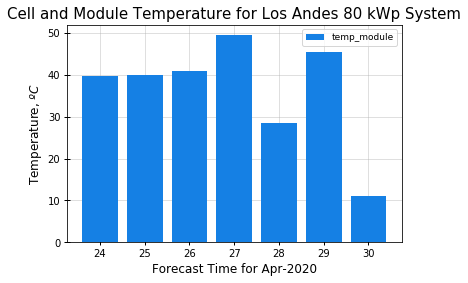

In [59]:
# Module Temperature Plot
plt.style.use('fast')

plt.bar(x, max_temp_cell, label='temp_module', color='#1580E4');

plt.rc('font', family='Helvetica')
plt.rcParams['axes.axisbelow'] = True;

plt.title('Cell and Module Temperature for {}'.format(LosAndesSys), fontname="Helvetica", fontsize=15);
plt.ylabel('Temperature, $ºC$', fontname="Helvetica", fontsize=12);
plt.xlabel('Forecast Time for {}-{}'.format(start.strftime("%b"), start.year), fontname="Helvetica", fontsize=12);

plt.tick_params(direction='inout', length=6, width=1, grid_alpha=0.5)

plt.xticks(x, int_days)
plt.ylim(0, None)
plt.grid(True);
plt.legend(fontsize=9);
plt.tight_layout;
plt.savefig('Module_Temperature.eps')

# Description of the Results
temp_module_results = list(zip(int_days, max_temp_cell));
temp_module_results = pd.DataFrame(temp_module_results, columns=['Day', 'Temp. Module']);
temp_module_results = temp_module_results.round(1);
temp_module_results.head()

### 6.7. ENERGY
In order to get easier the value of the daily energy, the ***Method 2*** is applied and then the function ```pvsystem.snlinverter``` is used in order to get a *'continuous'* data of AC power during each day (and not only the maximum value as stated with ***Method 1***.

In [60]:
# Continuos Calculus of AC Power for Both Systems at Los Andes University
cont_ACPow_SysA = pvsystem.snlinverter(sc_SysA['v_mp'], sc_SysA['p_mp'], inverter_A)/kilo;
cont_ACPow_SysB = pvsystem.snlinverter(sc_SysB['v_mp'], sc_SysB['p_mp'], inverter_B)/kilo;

___
**Note:** When AC power is less than the startup power required ($P_{s0}$ as parametrically stated by PVLIB-Python), then the function ```pvsystem.snlinverter``` set the variable AC power to $\: -1 · |P_{nt}|\:$ to represent nightly power losses.

If the user considers this ot truly relevant, with the code snipped below can change those negative values to zero.

```python
d = {-1:0}
cont_ACPow_SysA = cont_ACPow_SysA.replace(d)
cont_ACPow_SysA.head()
```
___

In [93]:
# Detailed AC Power

# SysA
detailed_ACPow_SysA = pd.DataFrame(cont_ACPow_SysA, columns=['AC_Power'])
detailed_ACPow_SysA['Day'] = detailed_ACPow_SysA.index.day
detailed_ACPow_SysA['Hour'] = detailed_ACPow_SysA.index.hour
detailed_ACPow_SysA = detailed_ACPow_SysA[['Day', 'Hour', 'AC_Power']]

# SysB
detailed_ACPow_SysB = pd.DataFrame(cont_ACPow_SysB, columns=['AC_Power'])
detailed_ACPow_SysB['Day'] = detailed_ACPow_SysB.index.day
detailed_ACPow_SysB['Hour'] = detailed_ACPow_SysB.index.hour
detailed_ACPow_SysB = detailed_ACPow_SysB[['Day', 'Hour', 'AC_Power']]

# Daily Total AC Power
daily_total_ACPow_SysA = pd.DataFrame(cont_ACPow_SysA, columns=['SysA'])
daily_total_ACPow_SysB = pd.DataFrame(cont_ACPow_SysB, columns=['SysB'])

daily_total_ACPow_SysA = daily_total_ACPow_SysA.resample('1d').sum();
daily_total_ACPow_SysB = daily_total_ACPow_SysB.resample('1d').sum();

# Delta Hour (Or Hour Resolution)
delta_hour = detailed_ACPow_SysA['Hour'][1] - detailed_ACPow_SysA['Hour'][0]

# Daily Energy
daily_energy_SysA = daily_total_ACPow_SysA * delta_hour
daily_energy_SysB = daily_total_ACPow_SysB * delta_hour

de_SysA = pd.DataFrame(daily_energy_SysA)
de_SysB = pd.DataFrame(daily_energy_SysB)
daily_energy = de_SysA.join(de_SysB)
daily_energy

,SysA,SysB
Datetime,,
2020-04-24 00:00:00-05:00,183409.137583,102874.271905
2020-04-25 00:00:00-05:00,161045.527942,90309.492183
2020-04-26 00:00:00-05:00,175568.839974,98469.872379
2020-04-27 00:00:00-05:00,137181.709832,76828.368501
2020-04-28 00:00:00-05:00,112070.559466,62819.573557
2020-04-29 00:00:00-05:00,149375.311302,83714.966865
2020-04-30 00:00:00-05:00,-6.000000,-3.660000


,Day,Energy_SysA,Energy_SysB,Total_Energy
0,24,183.4,102.9,286.3
1,25,161.0,90.3,251.4
2,26,175.6,98.5,274.0
3,27,137.2,76.8,214.0
4,28,112.1,62.8,174.9


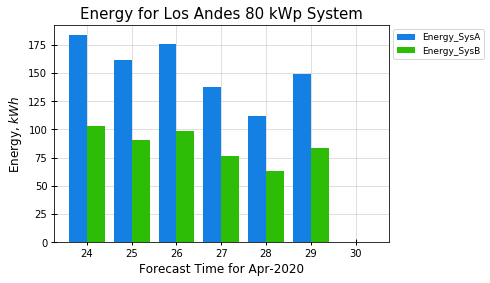

In [100]:
# Energy Plot

plt.style.use('fast')

plt.bar(r1, daily_energy['SysA']/1e3, width, label='Energy_SysA', color='#1580E4');
plt.bar(r3, daily_energy['SysB']/1e3, width, label='Energy_SysB', color='#2DBD07');

plt.rc('font', family='Helvetica')
plt.rcParams['axes.axisbelow'] = True;

plt.title('Energy for {}'.format(LosAndesSys), fontname="Helvetica", fontsize=15);
plt.ylabel('Energy, $kWh$', fontname="Helvetica", fontsize=12);
plt.xlabel('Forecast Time for {}-{}'.format(start.strftime("%b"), start.year), fontname="Helvetica", fontsize=12);

plt.tick_params(direction='inout', length=6, width=1, grid_alpha=0.5)

plt.xticks(x + width/2, int_days)
plt.ylim(0, None)
plt.grid(True);
plt.legend(loc="upper left", bbox_to_anchor=(1,1), fontsize=9);
plt.tight_layout;
plt.savefig('Energy_Manual.eps')

# Description of the Results
total_energy = daily_energy['SysA']/1e3 + daily_energy['SysB']/1e3

energy_results = list(zip(int_days, daily_energy['SysA']/1e3, daily_energy['SysB']/1e3, total_energy));
energy_results = pd.DataFrame(energy_results, columns=['Day', 'Energy_SysA', 'Energy_SysB',
                                                                           'Total_Energy']);
energy_results = energy_results.round(1);
energy_results.head()

___
## PART 7: PV SYSTEM MODELLING AND OUTPUTS COMPARISON

System outputs (DC voltage, DC current, DC power, AC power, module temperature and daily energy)*manually calculated* by the code sequence developed in this *Jupyter Notebook*. 

It is highlighted as manually calculated since later it will be compared with the *ModelChain* class.

### 7.1. SYSTEM MODEL CHAIN INITIALIZATION

More info at: https://cwhanse-pvlib-python.readthedocs.io/en/latest/generated/pvlib.modelchain.ModelChain.html#pvlib.modelchain.ModelChain

In [ ]:
# Use a ModelChain object to calculate modeling intermediates
mc_A = ModelChain(system_A, location, aoi_model='physical', spectral_model='no_loss', losses_model='pvwatts', name='system_A')
mc_B = ModelChain(system_B, location, aoi_model='physical', spectral_model='no_loss', losses_model='pvwatts', name='system_B')

# Extract relevant data from Model Chain
mc_A.run_model(data_weatherforecast.index, data_weatherforecast);
mc_B.run_model(data_weatherforecast.index, data_weatherforecast);

# ModelChain contains: name, orientation_strategy, clearsky_model, transposition_model, solar_position_method, ...
# ..., airmass_model, dc_model, ac_model, aoi_model, spectral_model, temp_model and losses_model

In [ ]:
#mc = ModelChain(pvwatts_system, location,
                 #aoi_model='no_loss', spectral_model='no_loss')

In [ ]:
sandia_modules = pvsystem.retrieve_sam('SandiaMod')
sandia_module = sandia_modules.Canadian_Solar_CS5P_220M___2009_

effective_irradiance = pvsystem.sapm_effective_irradiance(poa_irrad.poa_direct, poa_irrad.poa_diffuse, 
                                                          absolute_airmass, aoi, sandia_module)

sapm_out = pvsystem.sapm(effective_irradiance, pvtemps['temp_cell'], sandia_module)
print(sapm_out.head())

plt.bar(conditions['Datetime'], curve_info['p_mp'])
plt.ylabel('DC Power (W)')


### 5.2. MODEL CHAIN IRRADIANCE PLOT

ModelChain objects provide convenience methods that can provide default selections for models and can also fill necessary input with modeled data. For example, no air temperature or wind speed data is provided in the input weather DataFrame, so the ModelChain object defaults to 20 C and 0 m/s. Also, if no irradiance transposition model is specified (keyword argument transposition for ModelChain), the ModelChain defaults to the *HayDavies* model.

In [ ]:
# Irradiance for Global System 80 kWp (System A -51.24 kWp plus Sytem B -28.82 kWp)
plt.style.use('fast')

mc_A.total_irrad.plot();

plt.rc('font', family='Helvetica')

plt.title('Irradiance for {}'.format(LosAndesSys), fontname="Helvetica", fontsize=15);
plt.ylabel('POA Irradiance, $W/m^2$', fontname="Helvetica", fontsize=12);
plt.xlabel('Forecast Time for {}-{}'.format(start.strftime("%b"), start.year), fontname="Helvetica", fontsize=12);

plt.gcf().autofmt_xdate();
date_format = mpl_dates.DateFormatter('%d');
plt.gca().xaxis.set_major_formatter(date_format);

plt.tick_params(direction='inout', length=6, width=1, grid_alpha=0.5)

plt.xticks(rotation=0)
plt.grid(True);
plt.legend(loc="upper left", bbox_to_anchor=(1,1), fontsize=9);
plt.tight_layout;
plt.savefig('ModelChain_Irradiance.eps')

### 5.3. MODEL CHAIN TEMPERATURES PLOT

In [ ]:
# Temperatures for Global System 80 kWp (System A -51.24 kWp plus Sytem B -28.82 kWp)
plt.style.use('fast')

mc_A.temps.plot()

plt.rc('font', family='Helvetica')

plt.title('Temperature for {}'.format(LosAndesSys), fontname="Helvetica", fontsize=15);
plt.ylabel('Temperature ($ºC$)', fontname="Helvetica", fontsize=12);
plt.xlabel('Forecast Time for {}-{}'.format(start.strftime("%b"), start.year), fontname="Helvetica", fontsize=12);

plt.gcf().autofmt_xdate();
date_format = mpl_dates.DateFormatter('%d');
plt.gca().xaxis.set_major_formatter(date_format);

plt.tick_params(direction='inout', length=6, width=1, grid_alpha=0.5)

plt.xticks(rotation=0)
plt.grid(True);
plt.legend(loc="upper left", bbox_to_anchor=(1,1), fontsize=9);
plt.tight_layout;
plt.savefig('ModelChain_Temperature.eps')

### 5.4. MODEL CHAIN AC POWER PLOT

In [ ]:
# Temperatures for System A -51.24 kWp
plt.style.use('fast')

mc_A.ac.plot(label='System A AC Power', color='#1580E4')

plt.rc('font', family='Helvetica')

plt.title('AC Power for {}'.format(sysA_name), fontname="Helvetica", fontsize=15);
plt.ylabel('AC Power, $W$', fontname="Helvetica", fontsize=12);
plt.xlabel('Forecast Time for {}-{}'.format(start.strftime("%b"), start.year), fontname="Helvetica", fontsize=12);

plt.gcf().autofmt_xdate();
date_format = mpl_dates.DateFormatter('%d');
plt.gca().xaxis.set_major_formatter(date_format);

plt.tick_params(direction='inout', length=6, width=1, grid_alpha=0.5)

plt.xticks(rotation=0)
plt.grid(True);
plt.legend(loc="upper left", bbox_to_anchor=(1,1), fontsize=9);
plt.tight_layout;
plt.savefig('ModelChain_ACPower_SysA.eps')

In [ ]:
# Temperatures for System A -51.24 kWp plus Sytem B -28.82 kWp)
plt.style.use('fast')

mc_B.ac.plot(label='System B AC Power', color='red')

plt.rc('font', family='Helvetica')

plt.title('AC Power for {}'.format(sysB_name), fontname="Helvetica", fontsize=15);
plt.ylabel('AC Power, $W$', fontname="Helvetica", fontsize=12);
plt.xlabel('Forecast Time for {}-{}'.format(start.strftime("%b"), start.year), fontname="Helvetica", fontsize=12);

plt.gcf().autofmt_xdate();
date_format = mpl_dates.DateFormatter('%d');
plt.gca().xaxis.set_major_formatter(date_format);

plt.tick_params(direction='inout', length=6, width=1, grid_alpha=0.5)

plt.xticks(rotation=0)
plt.grid(True);
plt.legend(loc="upper left", bbox_to_anchor=(1,1), fontsize=9);
plt.tight_layout;
plt.savefig('ModelChain_ACPower_SysB.eps')

___
## PART 6: PV SYSTEM OUTPUS

### 6.1. Energy

In [ ]:
number_days = end.day - start.day;

energy_days_A = np.zeros(number_days)
energy_days_B = np.zeros(number_days)

for day in range(number_days):
    energy_days_A[day] = mc_A.ac.loc[pd.DatetimeIndex(mc_A.ac.index).day == day+1].sum()
    energy_days_B[day] = mc_B.ac.loc[pd.DatetimeIndex(mc_B.ac.index).day == day+1].sum()

N = number_days
ind = np.arange(1,N+1)  # the x locations for the groups
width = 0.27       # the width of the bars

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
rects1 = ax.bar(ind, energy_days_A/1e3, width, color='r')
rects2 = ax.bar(ind+width, energy_days_B/1e3, width, color='g')
ax.set_ylabel('Energia producida [kWh]')
ax.set_xlabel('Meses')
ax.set_xticks(ind)
ax.legend( (rects1[0], rects2[0]), ('Sistema A', 'Sistema B') )
plt.show()